<a href="https://colab.research.google.com/github/eric6450/2023-scEpieQTL-summer/blob/main/scEpi_eQTL_summer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install jedi

In [ ]:
!pip install  scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [ ]:
import os
import h5py
import scipy
import seaborn as sns
import anndata
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scvi; print(scvi.__version__)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100, figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2
sc.settings.max_memory=5
sc.settings.autoshow=False
#sc.settings.ScanpyConfig(autoshow=False,max_memory=4)

1.0.2


In [ ]:
#@title
!mkdir data
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5 -O data/pbmc10k_filtered_feature_bc_matrix.h5
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peaks.bed -O data/peaks.bed
!mkdir write


mkdir: cannot create directory ‘data’: File exists
--2023-07-31 02:34:11--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192125528 (183M) [binary/octet-stream]
Saving to: ‘data/pbmc10k_filtered_feature_bc_matrix.h5’

data/pbmc10k_filter 100%[===================>] 183.22M  96.2MB/s    in 1.9s    

2023-07-31 02:34:13 (96.2 MB/s) - ‘data/pbmc10k_filtered_feature_bc_matrix.h5’ saved [192125528/192125528]

--2023-07-31 02:34:13--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peaks.bed
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connec

In [ ]:
results_file = 'write/pbmc10k.h5ad'  # the file that will store the analysis results

In [ ]:
peak = pd.read_csv('data/peaks.bed', sep='\t', names=['chr','start','end'], comment="#")
peak

chr   start     end
0             chr1    9790   10675
1             chr1  180599  181702
2             chr1  191168  192093
3             chr1  267565  268455
4             chr1  270876  271770
...            ...     ...     ...
143882  KI270713.1   21434   22340
143883  KI270713.1   26201   26826
143884  KI270713.1   29624   30457
143885  KI270713.1   31340   32243
143886  KI270713.1   36927   37836

[143887 rows x 3 columns]

In [ ]:
ad = sc.read_10x_h5('/content/data/pbmc10k_filtered_feature_bc_matrix.h5', gex_only=False)
ad

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11898 × 180488
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
ad_rna = ad[:, ad.var['feature_types']=='Gene Expression']
ad_atac = ad[:, ad.var['feature_types']=='Peaks']

## 載入eQTL檔案  ##

In [ ]:
all762eqtl_ID=np.load('/content/drive/MyDrive/scEpieQTL/all762eqtl_ID.npy') #沒有附gene的eQTL

In [ ]:
all762eqtl_ID.shape

(786,)

In [ ]:
all762eqtl_ID

array(['chr10_49194771_A_C_b38', 'chr10_80535642_G_A_b38',
       'chr19_57500079_C_T_b38', 'chr8_30812874_G_T_b38',
       'chr1_16678275_G_T_b38', 'chr19_10432131_G_A_b38',
       'chr16_16232607_T_G_b38', 'chr3_119323125_G_A_b38',
       'chr15_50107475_T_C_b38', 'chr2_189661498_C_T_b38',
       'chr17_3917404_A_G_b38', 'chr16_16232314_G_A_b38',
       'chr19_35432956_T_C_b38', 'chr11_329181_C_G_b38',
       'chr12_553672_T_C_b38', 'chr17_2304032_G_A_b38',
       'chr4_1684252_T_G_b38', 'chrX_23743331_C_A_b38',
       'chr1_11719442_T_C_b38', 'chr16_11370526_C_G_b38',
       'chr2_201781238_C_T_b38', 'chr10_101032154_C_A_b38',
       'chr15_78131254_A_C_b38', 'chr6_116462167_G_A_b38',
       'chr11_108498446_G_A_b38', 'chr6_82364851_A_G_b38',
       'chr9_114315893_T_A_b38', 'chr6_37517014_T_C_b38',
       'chr16_89193285_G_A_b38', 'chr17_60677901_C_A_b38',
       'chr2_120223118_G_A_b38', 'chr1_15411869_A_C_b38',
       'chr19_55071333_G_C_b38', 'chr14_52697146_G_C_b38',
       'ch

In [ ]:
'''
# 輸入和輸出檔案路徑 文策先提供原始eqtl對應到的gene，有17個gene name對不到的我先保留ensembl id
input_file = '/content/drive/MyDrive/scEpieQTL/786_peak_id_gene_name.txt'
output_file = '/content/drive/MyDrive/scEpieQTL/786_peak_id_gene_name.npy'

# 讀取文字檔
with open(input_file, 'r') as file:
    data = file.readlines()

# 去除換行符號並將每行文字轉換為 Unicode 字串
data = [line.strip().encode('utf-8').decode('unicode_escape') for line in data]

# 將資料轉換成 NumPy 數組
data = np.array(data, dtype='<U')

# 儲存成 npy 檔案
np.save(output_file, data)
'''

"\n# 輸入和輸出檔案路徑 文策先提供原始eqtl對應到的gene，有17個gene name對不到的我先保留ensembl id\ninput_file = '/content/drive/MyDrive/scEpieQTL/786_peak_id_gene_name.txt'\noutput_file = '/content/drive/MyDrive/scEpieQTL/786_peak_id_gene_name.npy'\n\n# 讀取文字檔\nwith open(input_file, 'r') as file:\n    data = file.readlines()\n\n# 去除換行符號並將每行文字轉換為 Unicode 字串\ndata = [line.strip().encode('utf-8').decode('unicode_escape') for line in data]\n\n# 將資料轉換成 NumPy 數組\ndata = np.array(data, dtype='<U')\n\n# 儲存成 npy 檔案\nnp.save(output_file, data)\n"

In [ ]:
all762eqtl_geneID=np.load('/content/drive/MyDrive/scEpieQTL/786_peak_id_gene_name.npy') #有附gene的eQTL

In [ ]:
all762eqtl_geneID.shape

(786,)

In [ ]:
all762eqtl_geneID #有附gene的eQTL

array(['chr10_49194771_A_C_b38 TMEM273',
       'chr10_80535642_G_A_b38 TSPAN14-AS1',
       'chr19_57500079_C_T_b38 ZNF773', 'chr8_30812874_G_T_b38 PPP2CB',
       'chr1_16678275_G_T_b38 MST1P2', 'chr19_10432131_G_A_b38 PDE4A',
       'chr16_16232607_T_G_b38 AC136624.1',
       'chr3_119323125_G_A_b38 ARHGAP31', 'chr15_50107475_T_C_b38 ATP8B4',
       'chr2_189661498_C_T_b38 ASNSD1', 'chr17_3917404_A_G_b38 P2RX1',
       'chr16_16232314_G_A_b38 NOMO3', 'chr19_35432956_T_C_b38 LINC01531',
       'chr11_329181_C_G_b38 AC136475.5',
       'chr12_553672_T_C_b38 AC006205.2',
       'chr17_2304032_G_A_b38 HNRNPA1P16', 'chr4_1684252_T_G_b38 FAM53A',
       'chrX_23743331_C_A_b38 ACOT9', 'chr1_11719442_T_C_b38 DRAXIN',
       'chr16_11370526_C_G_b38 AC009121.2', 'chr2_201781238_C_T_b38 ALS2',
       'chr10_101032154_C_A_b38 PDZD7', 'chr15_78131254_A_C_b38 CIB2',
       'chr6_116462167_G_A_b38 CALHM6', 'chr11_108498446_G_A_b38 POGLUT3',
       'chr6_82364851_A_G_b38 TPBG', 'chr9_114315893_T_A_

In [ ]:
all368eqtl_gexdiff0721=np.load('/content/drive/MyDrive/scEpieQTL/基因表現差值的all_368eqtl_gexdiff0721.npy') #基因表現差值的368x11898 npy檔

In [ ]:
all368eqtl_gexdiff0721.shape

(368, 11898)

In [ ]:
all368eqtl_gexdiff0721

array([[ 0.        , -0.00205749, -0.00064313, ...,  0.03881747,
         0.        , -0.00147051],
       [ 0.00121405,  0.        ,  0.00375967, ...,  0.        ,
         0.        ,  0.0047045 ],
       [ 0.00263033, -0.00385789,  0.        , ...,  0.        ,
         0.0006361 , -0.00012213],
       ...,
       [ 0.        ,  0.        ,  0.00193259, ..., -0.00243324,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [ ]:
#scaler = StandardScaler() #對數據做標準化Standardlization 創建StandardScaler對象
#all368eqtl_gexdiff0721 = scaler.fit_transform(all368eqtl_gexdiff0721) # 使用fit_transform對數據進行標準化

In [ ]:
#scaler = MinMaxScaler() # 對數據做標準化normalization 創建MinMaxScaler物件
# 使用MinMaxScaler進行正規化
#all368eqtl_gexdiff0721 = scaler.fit_transform(all368eqtl_gexdiff0721)

In [ ]:
# = all368eqtl_gexdiff0721 / np.max(np.abs(all368eqtl_gexdiff0721)) #要改成每一列自己做normalization

In [ ]:
# 每一列除以该列的最大绝对值
max_abs_vals = np.max(np.abs(all368eqtl_gexdiff0721.T), axis=0) # 将行和列交换，使用numpy.transpose()方法或是.T
normalized_data = all368eqtl_gexdiff0721.T / max_abs_vals

In [ ]:
max_abs_vals

array([0.07700467, 0.02727497, 0.03702911, 0.03645349, 0.04956769,
       0.02145313, 0.06101352, 0.0215312 , 0.05008259, 0.03172792,
       0.0542371 , 0.07618016, 0.09098186, 0.03275575, 0.08123003,
       0.0520743 , 0.04818928, 0.02498027, 0.02639768, 0.04915811,
       0.06524187, 0.06586124, 0.07822677, 0.0924167 , 0.0570969 ,
       0.09565264, 0.1591664 , 0.05532476, 0.12595177, 0.03386131,
       0.07833236, 0.07863069, 0.03781638, 0.01728608, 0.06861785,
       0.08448854, 0.05746575, 0.04468761, 0.04866883, 0.09366278,
       0.16910553, 0.03895763, 0.08786047, 0.06254247, 0.06660014,
       0.02579854, 0.02411303, 0.04829517, 0.02446108, 0.06015944,
       0.0570709 , 0.03148842, 0.02387561, 0.0626626 , 0.03022942,
       0.09657151, 0.03113311, 0.04935253, 0.0585954 , 0.1303261 ,
       0.16189069, 0.05181655, 0.03811929, 0.04571903, 0.04356456,
       0.03679851, 0.05269599, 0.03139978, 0.03291346, 0.01919152,
       0.0383193 , 0.09261242, 0.04305554, 0.03845525, 0.03810

In [ ]:
normalized_data.shape

(11898, 368)

In [ ]:
all368eqtl_gexdiff0721=normalized_data.T

In [ ]:
all368eqtl_gexdiff0721

array([[ 0.        , -0.02671906, -0.00835188, ...,  0.50409234,
         0.        , -0.01909632],
       [ 0.0445115 ,  0.        ,  0.13784343, ...,  0.        ,
         0.        ,  0.17248408],
       [ 0.07103413, -0.10418528,  0.        , ...,  0.        ,
         0.01717845, -0.00329831],
       ...,
       [ 0.        ,  0.        ,  0.01716564, ..., -0.0216125 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [ ]:
for i in range(0,368):
  #ad_rna.obs[f"all368eqtl_gexdiff0721_{i:d}"] = pd.Categorical(all368eqtl_gexdiff0721[i,:])
  ad_rna.obs[f"all368eqtl_gexdiff0721_{i:d}"] = all368eqtl_gexdiff0721[i,:]

<ipython-input-28-7e2e068d8cc6>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_rna.obs[f"all368eqtl_gexdiff0721_{i:d}"] = all368eqtl_gexdiff0721[i,:]
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
<ipython-input-28-7e2e068d8cc6>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad_rna.obs[f"all368eqtl_gexdiff0721_{i:d}"] = all368eqtl_gexdiff07

In [ ]:
all368eqtl_gexdiff = pd.DataFrame(np.load('/content/drive/MyDrive/scEpieQTL/基因表現差值的all_368eqtl_gexdiff0721.npy'))

In [ ]:
all368eqtl_gexdiff.T.describe()

0             1             2             3             4    \
count  11898.000000  11898.000000  11898.000000  11898.000000  11898.000000   
mean       0.000978      0.000370     -0.000469     -0.000341      0.000982   
std        0.005473      0.003307      0.003973      0.004112      0.006512   
min       -0.027217     -0.026448     -0.037029     -0.036441     -0.036482   
25%        0.000000      0.000000     -0.001509      0.000000     -0.001204   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000425      0.000000      0.003492   
max        0.077005      0.027275      0.025345      0.036453      0.049568   

                5             6             7             8             9    \
count  11898.000000  11898.000000  11898.000000  11898.000000  11898.000000   
mean       0.000014      0.001070      0.000075      0.000931     -0.000028   
std        0.001868      0.005216      0.001434      0.004840      0.002153   
min       -0.014943     -0.029633     -0.019692     -0.031178     -0.031728   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.001940      0.000000   
max        0.021453      0.061014      0.021531      0.050083      0.027508   

       ...           358           359           360           361  \
count  ...  11898.000000  11898.000000  11898.000000  11898.000000   
mean   ...     -0.000107      0.001024     -0.000373     -0.000164   
std    ...      0.006071      0.006633      0.002771      0.004677   
min    ...     -0.063854     -0.053771     -0.057910     -0.031095   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      0.050892      0.116849      0.038005      0.038584   

                362           363           364           365           366  \
count  11898.000000  11898.000000  11898.000000  11898.000000  11898.000000   
mean      -0.000110      0.000663     -0.000093      0.002518     -0.000036   
std        0.004211      0.006166      0.008315      0.008780      0.002392   
min       -0.031166     -0.104724     -0.093591     -0.056986     -0.053373   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.001999      0.000000   
max        0.025766      0.123096      0.077229      0.112585      0.041484   

                367  
count  11898.000000  
mean      -0.000131  
std        0.002696  
min       -0.037256  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        0.025450  

[8 rows x 368 columns]

In [ ]:
all368eqtl_gexdiff_std = all368eqtl_gexdiff.T.describe().loc['std']

In [ ]:
all368eqtl_gexdiff_std

0      0.005473
1      0.003307
2      0.003973
3      0.004112
4      0.006512
         ...   
363    0.006166
364    0.008315
365    0.008780
366    0.002392
367    0.002696
Name: std, Length: 368, dtype: float64

In [ ]:
'''
# 輸入和輸出檔案路徑 義弘共368個eqtl影響基因位於model include(min cell>500)，基因共355個(備註:使用上方檔案取有出現的，基因名有些需去除addition部分)
input_file = '/content/drive/MyDrive/scEpieQTL/368eqtl_gene.txt'
output_file = '/content/drive/MyDrive/scEpieQTL/368eqtl_gene.npy'

# 讀取文字檔
with open(input_file, 'r') as file:
    data = file.readlines()

# 去除換行符號並將每行文字轉換為 Unicode 字串
data = [line.strip().encode('utf-8').decode('unicode_escape') for line in data]

# 將資料轉換成 NumPy 數組
data = np.array(data, dtype='<U')

# 儲存成 npy 檔案
np.save(output_file, data)
'''

"\n# 輸入和輸出檔案路徑 義弘共368個eqtl影響基因位於model include(min cell>500)，基因共355個(備註:使用上方檔案取有出現的，基因名有些需去除addition部分)\ninput_file = '/content/drive/MyDrive/scEpieQTL/368eqtl_gene.txt'\noutput_file = '/content/drive/MyDrive/scEpieQTL/368eqtl_gene.npy'\n\n# 讀取文字檔\nwith open(input_file, 'r') as file:\n    data = file.readlines()\n\n# 去除換行符號並將每行文字轉換為 Unicode 字串\ndata = [line.strip().encode('utf-8').decode('unicode_escape') for line in data]\n\n# 將資料轉換成 NumPy 數組\ndata = np.array(data, dtype='<U')\n\n# 儲存成 npy 檔案\nnp.save(output_file, data)\n"

In [ ]:
#eqtl368_gene=np.load('/content/drive/MyDrive/scEpieQTL/368eqtl_gene.npy') #0717找出的368個eQTL

In [ ]:
#eqtl368_gene.shape

In [ ]:
#eqtl368_gene

In [ ]:
eqtl368_geneID0719=np.load('/content/drive/MyDrive/scEpieQTL/all_368eqtlID_gane_name.npy') #0719找出的368個eQTL

In [ ]:
eqtl368_geneID0719.shape

(368,)

In [ ]:
eqtl368_geneID0719

array(['chr10_80535642_G_A_b38 TSPAN14-AS1',
       'chr8_30812874_G_T_b38 PPP2CB', 'chr19_10432131_G_A_b38 PDE4A',
       'chr3_119323125_G_A_b38 ARHGAP31', 'chr15_50107475_T_C_b38 ATP8B4',
       'chr2_189661498_C_T_b38 ASNSD1', 'chr17_3917404_A_G_b38 P2RX1',
       'chr16_16232314_G_A_b38 NOMO3', 'chrX_23743331_C_A_b38 ACOT9',
       'chr2_201781238_C_T_b38 ALS2', 'chr6_116462167_G_A_b38 CALHM6',
       'chr17_60677901_C_A_b38 BCAS3', 'chr1_15411869_A_C_b38 EFHD2-AS1',
       'chr19_55071333_G_C_b38 RDH13', 'chr14_52697146_G_C_b38 PSMC6',
       'chr10_75210855_G_C_b38 VDAC2', 'chr12_121210329_G_T_b38 P2RX4',
       'chr16_3086918_T_C_b38 AC108134.3', 'chr15_90914580_T_G_b38 FURIN',
       'chr5_135999638_G_A_b38 TGFBI', 'chr1_180158613_C_T_b38 QSOX1',
       'chr16_15949317_C_G_b38 ABCC1', 'chr3_32391861_C_A_b38 CMTM7',
       'chr16_88548089_C_G_b38 ZFPM1-AS1',
       'chr13_43023570_C_T_b38 DNAJC15', 'chr4_168504221_G_A_b38 DDX60L',
       'chr18_24039967_A_G_b38 TTC39C', 'chr17_

In [ ]:
#all762eqtl=np.load('/content/drive/MyDrive/scEpieQTL/有根據原始ATAC檔區分的修改後0714verall762eqtl_changestate3group0714.npy')
#有根據原始ATAC檔區分的 all762eqtl_changestate3group0711
#noc = no change
#clo2op = close to open
#op2clo = open to close

In [ ]:
#all762eqtl.shape

In [ ]:
#all762eqtl #有根據原始ATAC檔區分的

In [ ]:
#for i in range(0,786):
#  ad_rna.obs[f"all762eqtl_{i:d}"] = pd.Categorical(all762eqtl[i,:])

In [ ]:
all_762eqtl=np.load('/content/drive/MyDrive/scEpieQTL/沒有根據原始ATAC檔區分(修改後0714ver)的all_762eqtl_threelabelby3group0714.npy')
#沒有根據原始ATAC檔區分的 all_762eqtl_threelabelby3group0714
#small med big

In [ ]:
all_762eqtl.shape

(786, 11898)

In [ ]:
all_762eqtl #沒有根據原始ATAC檔區分的 all_762eqtl_threelabelby3group0714 (last version)

array([['small', 'big', 'med', ..., 'med', 'med', 'med'],
       ['small', 'big', 'small', ..., 'big', 'med', 'big'],
       ['big', 'big', 'big', ..., 'med', 'big', 'med'],
       ...,
       ['med', 'med', 'med', ..., 'med', 'med', 'med'],
       ['med', 'small', 'med', ..., 'small', 'small', 'small'],
       ['med', 'med', 'med', ..., 'med', 'big', 'med']], dtype='<U5')

In [ ]:
for i in range(0,786):
  ad_rna.obs[f"all_762eqtl_{i:d}"] = pd.Categorical(all_762eqtl[i,:])

<ipython-input-47-07051fae0cea>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad_rna.obs[f"all_762eqtl_{i:d}"] = pd.Categorical(all_762eqtl[i,:])
<ipython-input-47-07051fae0cea>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad_rna.obs[f"all_762eqtl_{i:d}"] = pd.Categorical(all_762eqtl[i,:])
<ipython-input-47-07051fae0cea>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [ ]:
# 文策提供的125 eqtl 分群 cluster0-3 2023/07/27
# 讀取CSV文件並儲存為DataFrame
data_frame = pd.read_csv('/content/drive/MyDrive/scEpieQTL/125_eqtl_cell_gmm_cluster_labels.csv')

# 去掉索引列，使用reset_index()方法，并指定drop=True
#data_frame = data_frame.reset_index(drop=True)

#指定要读取的列，去掉第一欄
data_frame.drop('Unnamed: 0', axis=1, inplace=True)

# 将行和列交换，使用transpose()方法
data_frame_transposed = data_frame.transpose()

# 将DataFrame转换为NumPy数组
data_array = data_frame_transposed.to_numpy()

# 在google drive儲存NumPy array為.npy檔
np.save('/content/drive/MyDrive/scEpieQTL/125_eqtl_cell_gmm_cluster_labels.npy', data_array)

In [ ]:
top125_eqtl=np.load('/content/drive/MyDrive/scEpieQTL/125_eqtl_cell_gmm_cluster_labels.npy',allow_pickle=True)

In [ ]:
top125_eqtl.shape

(125, 11898)

In [ ]:
top125_eqtl

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 1, 2, ..., 1, 2, 2],
       [0, 0, 0, ..., 2, 1, 1],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
for i in range(0,125):
  ad_rna.obs[f"top125_eqtl_{i:d}"] = pd.Categorical(top125_eqtl[i,:])

<ipython-input-52-573354323eca>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad_rna.obs[f"top125_eqtl_{i:d}"] = pd.Categorical(top125_eqtl[i,:])
<ipython-input-52-573354323eca>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad_rna.obs[f"top125_eqtl_{i:d}"] = pd.Categorical(top125_eqtl[i,:])
<ipython-input-52-573354323eca>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [ ]:
top125_eqtl_ID=data_frame_transposed.index.to_numpy()

In [ ]:
top125_eqtl_ID

array(['chr17_3917404_A_G_b38', 'chr19_2775725_C_T_b38',
       'chr16_56610738_C_A_b38', 'chr13_110520681_C_G_b38',
       'chr11_2902596_A_G_b38', 'chr20_47727572_G_A_b38',
       'chr5_1104823_C_T_b38', 'chr10_129467281_C_T_b38',
       'chr4_139872577_G_C_b38', 'chr1_65421825_C_G_b38',
       'chr6_10723216_A_C_b38', 'chr9_98120227_A_G_b38',
       'chr16_87407681_G_A_b38', 'chr19_39941933_C_T_b38',
       'chr4_168504188_A_G_b38', 'chr12_9943487_G_C_b38',
       'chr13_30738041_A_T_b38', 'chr22_35410245_G_T_b38',
       'chr17_39926578_T_C_b38', 'chr2_74958729_G_T_b38',
       'chr17_27631065_A_G_b38', 'chr1_15411869_A_C_b38',
       'chr9_133418269_T_C_b38', 'chr21_42654602_A_G_b38',
       'chr9_5841963_G_A_b38', 'chr5_135999638_G_A_b38',
       'chr20_46118447_G_A_b38', 'chr13_45120004_T_C_b38',
       'chr21_42738295_C_A_b38', 'chr17_37643522_G_A_b38',
       'chr16_84775016_T_G_b38', 'chr3_32245299_G_A_b38',
       'chr15_42359702_G_C_b38', 'chr2_196799713_C_T_b38',
       'c

In [ ]:
'''
# 文策提供的top10 eqtl 分群 cluster0-3
# 讀取CSV文件並儲存為DataFrame
data_frame = pd.read_csv('/content/drive/MyDrive/scEpieQTL/top10_eqtl_cell_gmm_cluster_labels.csv')

# 去掉索引列，使用reset_index()方法，并指定drop=True
#data_frame = data_frame.reset_index(drop=True)

#指定要读取的列，去掉第一欄
data_frame.drop('Unnamed: 0', axis=1, inplace=True)

# 将行和列交换，使用transpose()方法
data_frame_transposed = data_frame.transpose()

# 将DataFrame转换为NumPy数组
data_array = data_frame_transposed.to_numpy()

# 在google drive儲存NumPy array為.npy檔
np.save('/content/drive/MyDrive/scEpieQTL/top10_eqtl_cell_gmm_cluster_labels.npy', data_array)
'''

"\n# 文策提供的top10 eqtl 分群 cluster0-3\n# 讀取CSV文件並儲存為DataFrame\ndata_frame = pd.read_csv('/content/drive/MyDrive/scEpieQTL/top10_eqtl_cell_gmm_cluster_labels.csv')\n\n# 去掉索引列，使用reset_index()方法，并指定drop=True\n#data_frame = data_frame.reset_index(drop=True)\n\n#指定要读取的列，去掉第一欄\ndata_frame.drop('Unnamed: 0', axis=1, inplace=True)\n\n# 将行和列交换，使用transpose()方法\ndata_frame_transposed = data_frame.transpose()\n\n# 将DataFrame转换为NumPy数组\ndata_array = data_frame_transposed.to_numpy()\n\n# 在google drive儲存NumPy array為.npy檔\nnp.save('/content/drive/MyDrive/scEpieQTL/top10_eqtl_cell_gmm_cluster_labels.npy', data_array)\n"

In [ ]:
#top10_eqtl=np.load('/content/drive/MyDrive/scEpieQTL/top10_eqtl_cell_gmm_cluster_labels.npy',allow_pickle=True)

In [ ]:
#top10_eqtl.shape

In [ ]:
#top10_eqtl

In [ ]:
#for i in range(0,10):
#  ad_rna.obs[f"top10_eqtl_{i:d}"] = pd.Categorical(top10_eqtl[i,:])

In [ ]:
#top10_eqtl_ID=data_frame_transposed.index.to_numpy()

In [ ]:
#top10_eqtl_ID

In [ ]:
#all_368eqtl=np.load('/content/drive/MyDrive/scEpieQTL/all_368eqtl_gexthreelabelby3group0719-1.npy')
#沒有根據原始ATAC檔區分的368個eqtl所影響的基因表現差值分群(big med small) 0719
#small med big

In [ ]:
#all_368eqtl=np.load('/content/drive/MyDrive/scEpieQTL/all_368eqtl_gexthreelabelby3group0720-1.npy')
#沒有根據原始ATAC檔區分的368個eqtl所影響的基因表現差值分群(big med small,zero) 0720
#small med big zero

In [ ]:
#all_368eqtl.shape

In [ ]:
#all_368eqtl

In [ ]:
#all_368eqtl=np.where(all_368eqtl == 'Zero', 'zero', all_368eqtl)

In [ ]:
#all_368eqtl

In [ ]:
#for i in range(0,368):
#  ad_rna.obs[f"all_368eqtl_{i:d}"] = pd.Categorical(all_368eqtl[i,:])

In [ ]:
#dfsb=pd.read_pickle('/content/drive/MyDrive/scEpieQTL/whole_blood_eqtl_.scbasset.seqs_762.pandas.pickle')

In [ ]:
#dfsb

In [ ]:
#sb786_index=dfsb.index.to_numpy()

In [ ]:
#sb786_index

In [ ]:
'''
sb786 = dfsb.to_numpy()
sb786 = np.round(sb786/(sb786.max()/22))
sb786 = sb786.astype(np.int8)
#附上ID的 scBasset predicition
'''

'\nsb786 = dfsb.to_numpy()\nsb786 = np.round(sb786/(sb786.max()/22))\nsb786 = sb786.astype(np.int8)\n#附上ID的 scBasset predicition\n'

In [ ]:
#sb786.shape

In [ ]:
#sb786

In [ ]:
#for i in range(0,1572):
#  ad_rna.obs[f"Peak762_{i:d}"] = pd.Categorical(sb786[i,:])

## Preprocess AnnData
ad = 11898 cells × 180488 genes＋atacs

ad_rna = 11898 cells × 36601 genes

ad_atac = 11898 cells × 143887 atacs

In [ ]:
#ad_rna = ad[:, ad.var['feature_types']=='Gene Expression']
#ad_atac = ad[:, ad.var['feature_types']=='Peaks']

ad_atac.var['chr'] = peak['chr'].values
ad_atac.var['start'] = peak['start'].values
ad_atac.var['end'] = peak['end'].values

# basic stats
sc.pp.filter_cells(ad_rna, min_genes=0)
sc.pp.filter_genes(ad_rna, min_cells=0)
sc.pp.filter_cells(ad_atac, min_genes=0)
sc.pp.filter_genes(ad_atac, min_cells=0)

# a gene need to be expressed in 5% cells
# a peak need to be accessible in 5% cells
thres = int(ad.shape[0]*0.05)
ad_rna = ad_rna[:, ad_rna.var['n_cells']>thres]
ad_atac = ad_atac[:, ad_atac.var['n_cells']>thres]

<ipython-input-77-2f67c8848319>:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad_atac.var['chr'] = peak['chr'].values
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['n_genes'] = number
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
chrs = ['chr'+str(i) for i in range(1,23)] + ['chrX', 'chrY']
ad_atac = ad_atac[:, ad_atac.var['chr'].isin(chrs)]
# ad_atac.write('/content/gdrive/MyDrive/Data_Colab/single_cell/atac_ad.h5ad')
ad_atac.write('./write/atac_ad.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [ ]:
adata = ad_rna

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

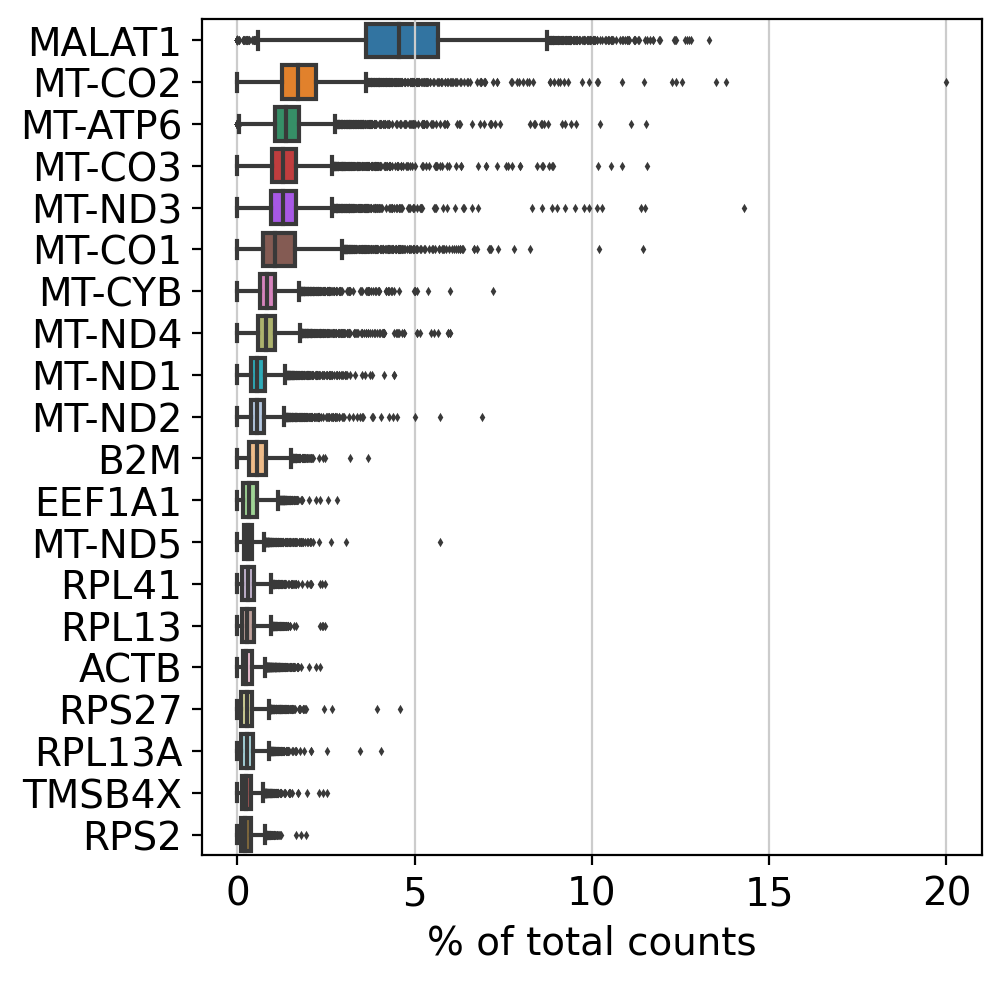

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [ ]:
def pp(adata):
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells

    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    #sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)
    #sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    #sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    #upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    #lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    #adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.n_genes_by_counts < 4000]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    #sc.pl.highly_variable_genes(adata)
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack') # Principal component analysis
    #sc.pl.pca(adata, color='CST3')
    #sc.pl.pca_variance_ratio(adata, log=True)
    adata.write(results_file)
    #adata
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20) # Computing the neighborhood graph

    sc.tl.umap(adata) # Embedding the neighborhood graph
    return adata


In [ ]:
adata = pp(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [ ]:
#Define colors from red to blue
n_clusters = 5
n_colors = plt.cm.jet(np.linspace(0.1,0.9,n_clusters))
#for i in range(n_clusters):
#  subdata = data(labels==i)
#  subdata.plot.hist(bins=bins, alpha=0.5, color=colors[i],label='cluster {}'.format(i))
n_colors

array([[0.        , 0.        , 0.9456328 , 1.        ],
       [0.        , 0.69215686, 1.        , 1.        ],
       [0.49019608, 1.        , 0.47754586, 1.        ],
       [1.        , 0.77051561, 0.        , 1.        ],
       [0.9456328 , 0.02977487, 0.        , 1.        ]])

In [ ]:
#import matplotlib.colors as mcolors
#mcolors.is_color_like(n_colors[4])
n_colors_str = [mcolors.to_hex(color) for color in n_colors]

True

In [ ]:
n_colors_str

['#0000f1', '#00b0ff', '#7dff7a', '#ffc400', '#f10800']

In [ ]:
sc.pl.umap(adata, color = 'n_genes',)
sc.pl.umap(adata, color = 'total_counts')
sc.pl.umap(adata, color = 'all368eqtl_gexdiff0721_0',
           colorbar_loc = 'right',
           cmap = 'RdBu_r', #cmap='jet',
           vmin = -3*all368eqtl_gexdiff_std[0],
           vmax = 3*all368eqtl_gexdiff_std[0],
           vcenter = 0,)
sc.pl.umap(adata, color = 'top125_eqtl_0',palette = n_colors_str) #palette = 'jet'
#sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', size=110, frameon=False, save='.pdf')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
sc.pl.umap(adata, color = ['top125_eqtl_0','all368eqtl_gexdiff0721_0'], colorbar_loc = 'right',cmap='RdBu_r',
           vmin = -3*all368eqtl_gexdiff_std[0], vmax = 3*all368eqtl_gexdiff_std[0],
           vcenter = 0, palette = n_colors_str); #,legend_loc = 'None'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
def cluster(adata):
  sc.tl.leiden(adata) # Clustering the neighborhood graph

In [ ]:
cluster(adata)

In [ ]:
#sc.pl.umap(adata, color=['leiden','CST3', 'NKG7', 'MS4A1', 'LYZ'])

In [ ]:
adata.write(results_file)

In [ ]:
def marker(adata): # Finding marker genes
  sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
  sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
  sc.settings.verbosity = 2  # reduce the verbosity
  sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
  sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
  adata.write(results_file)
  sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
  sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

ranking genes
    finished (0:00:23)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

ranking genes
    finished (0:02:27)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


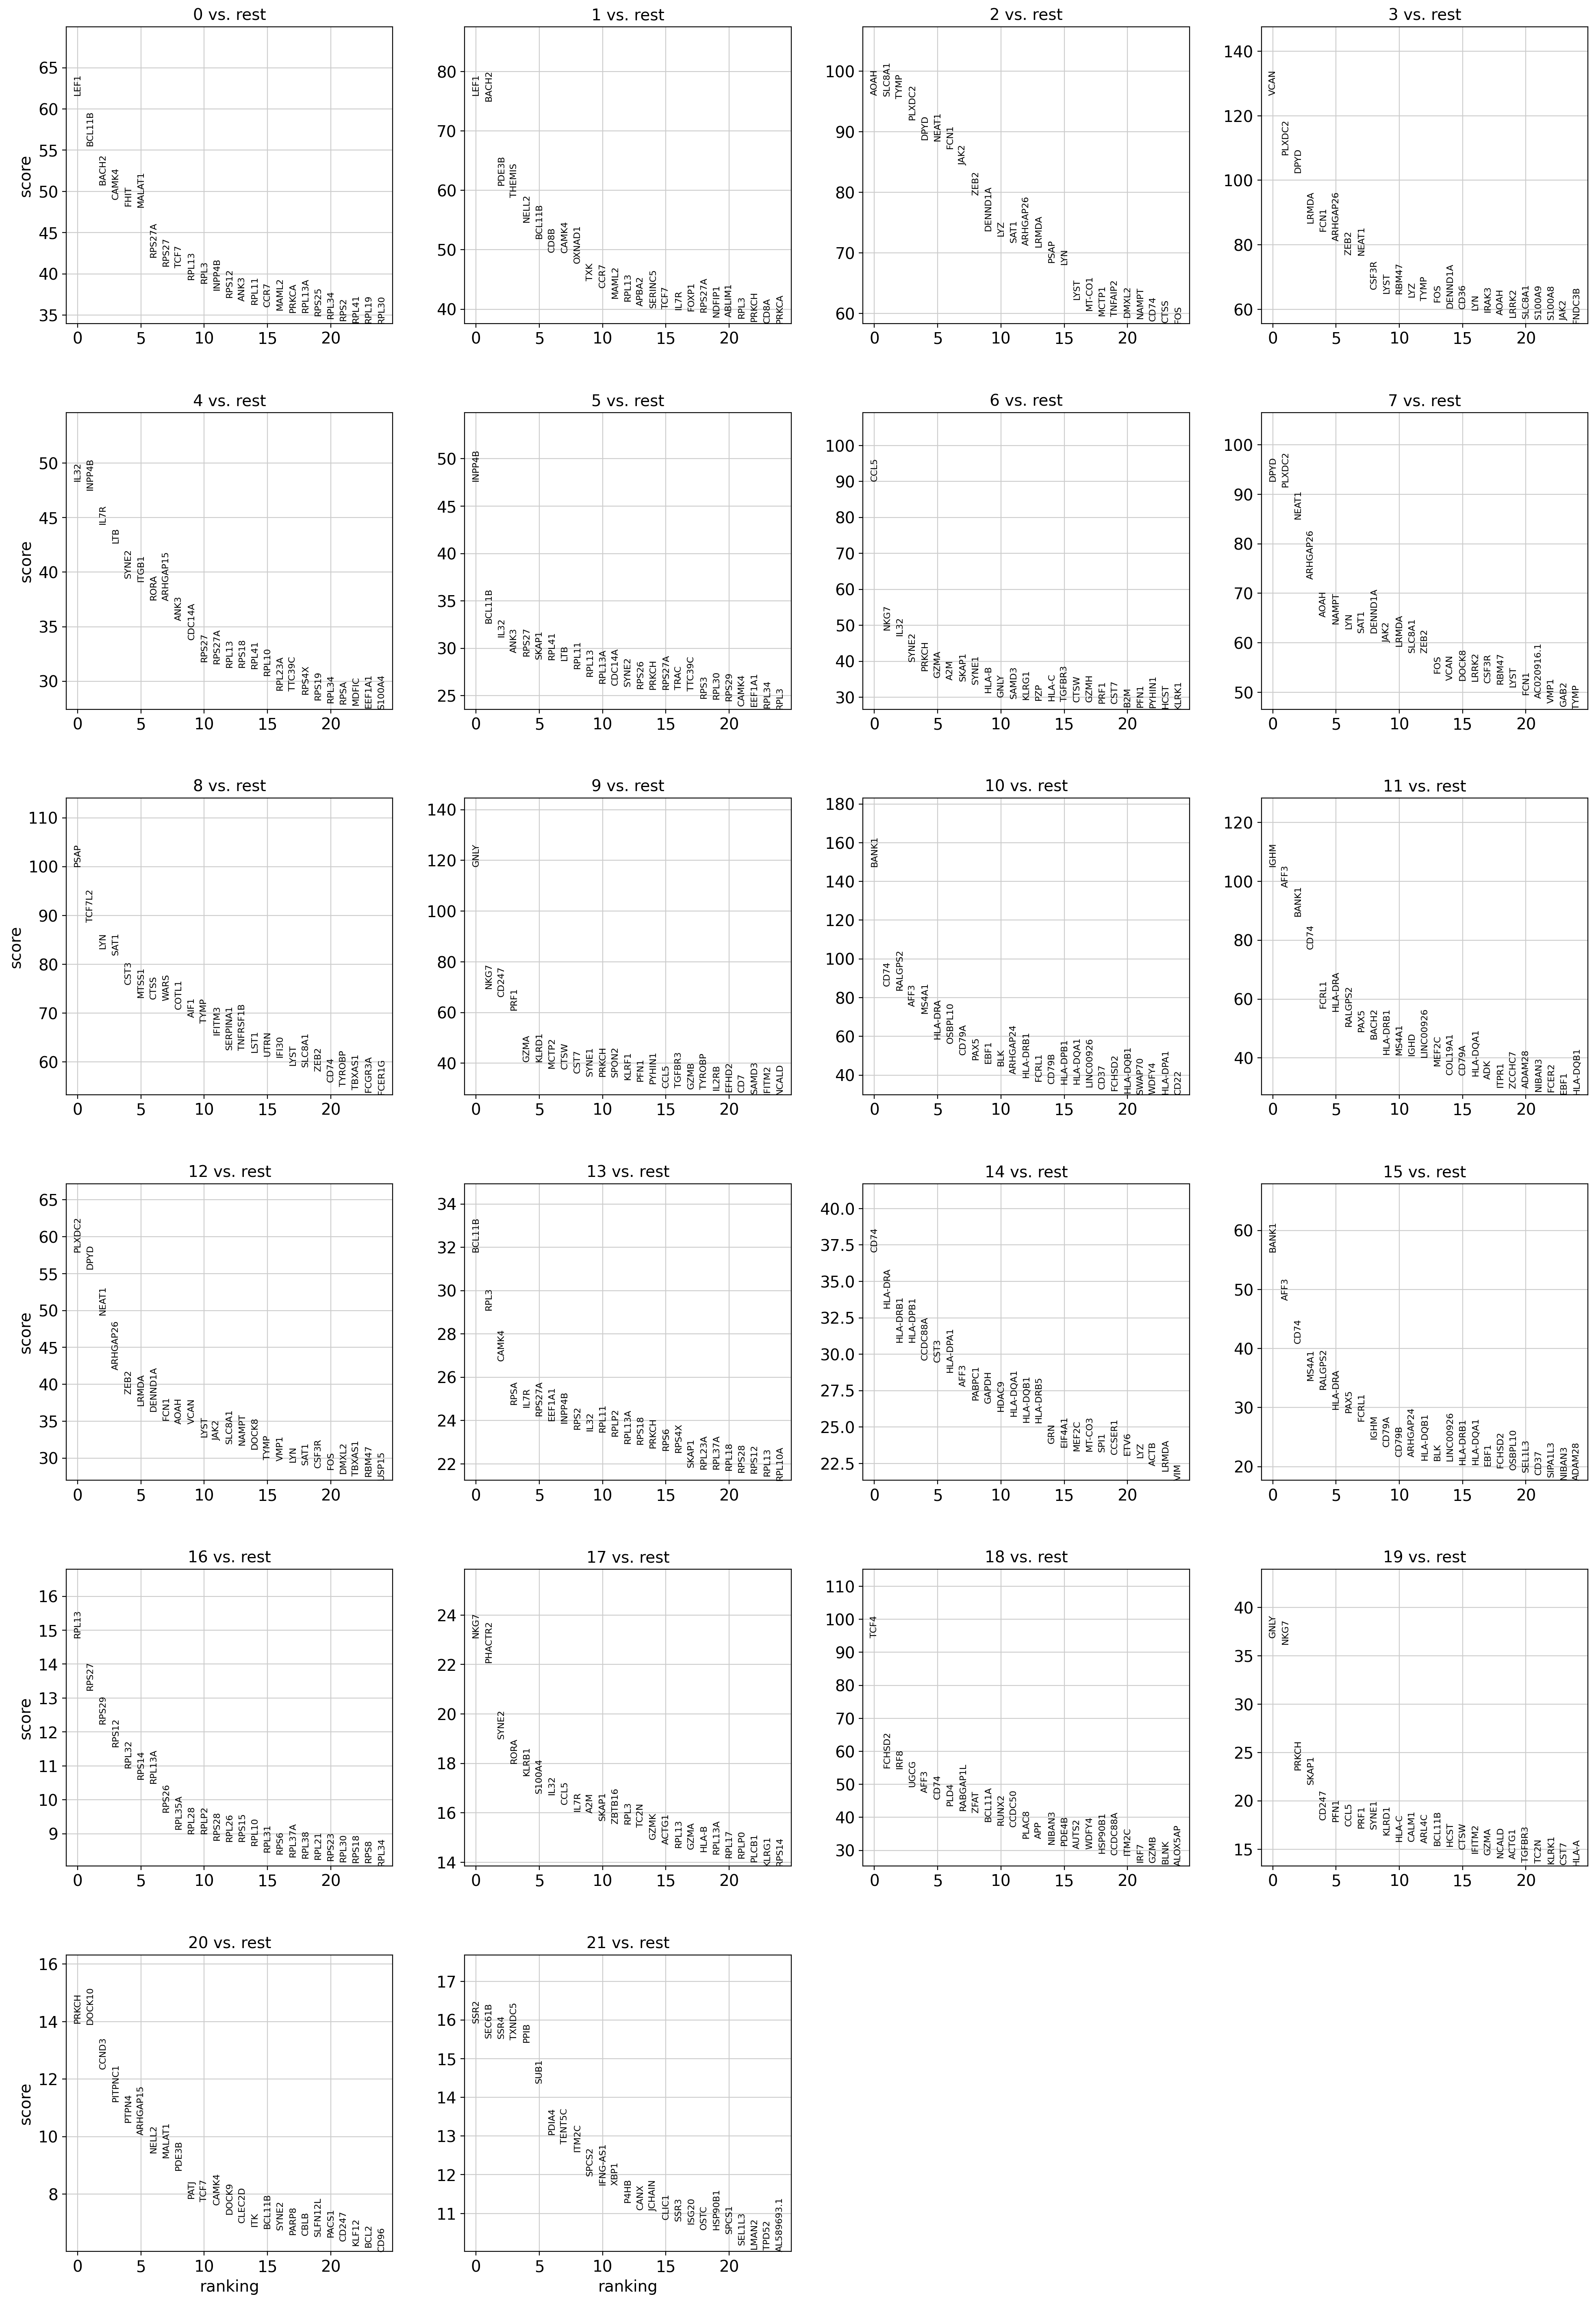

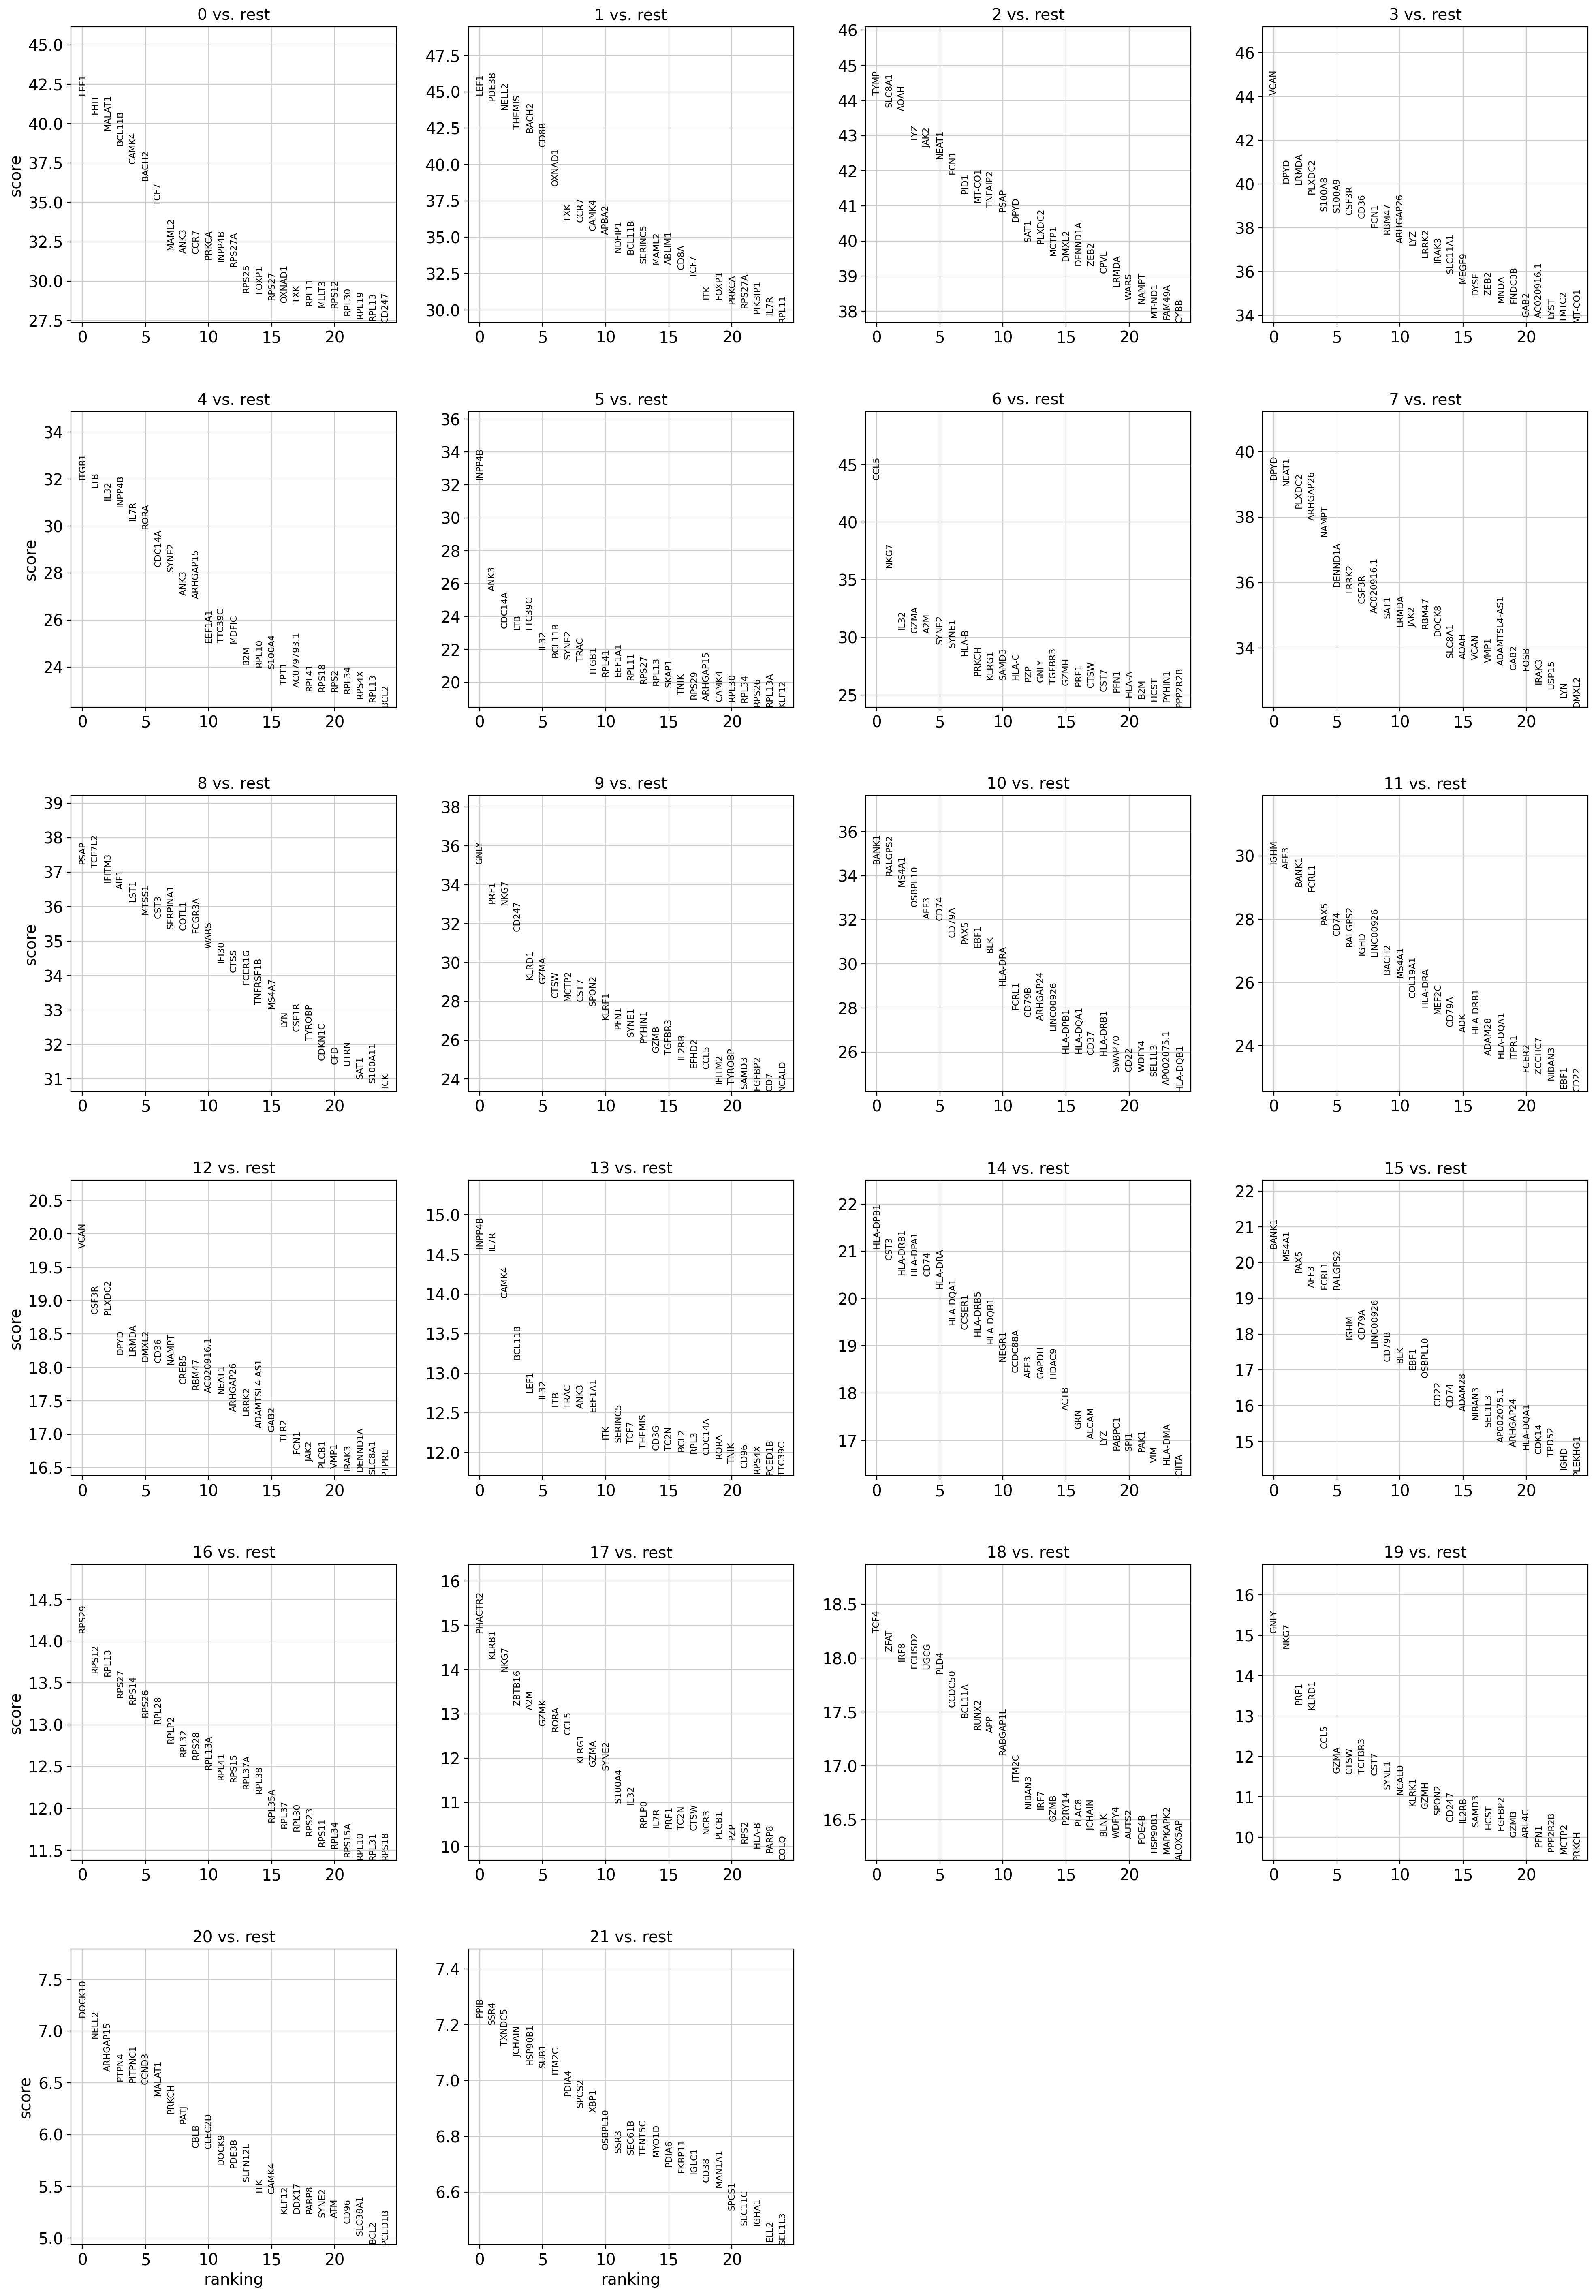

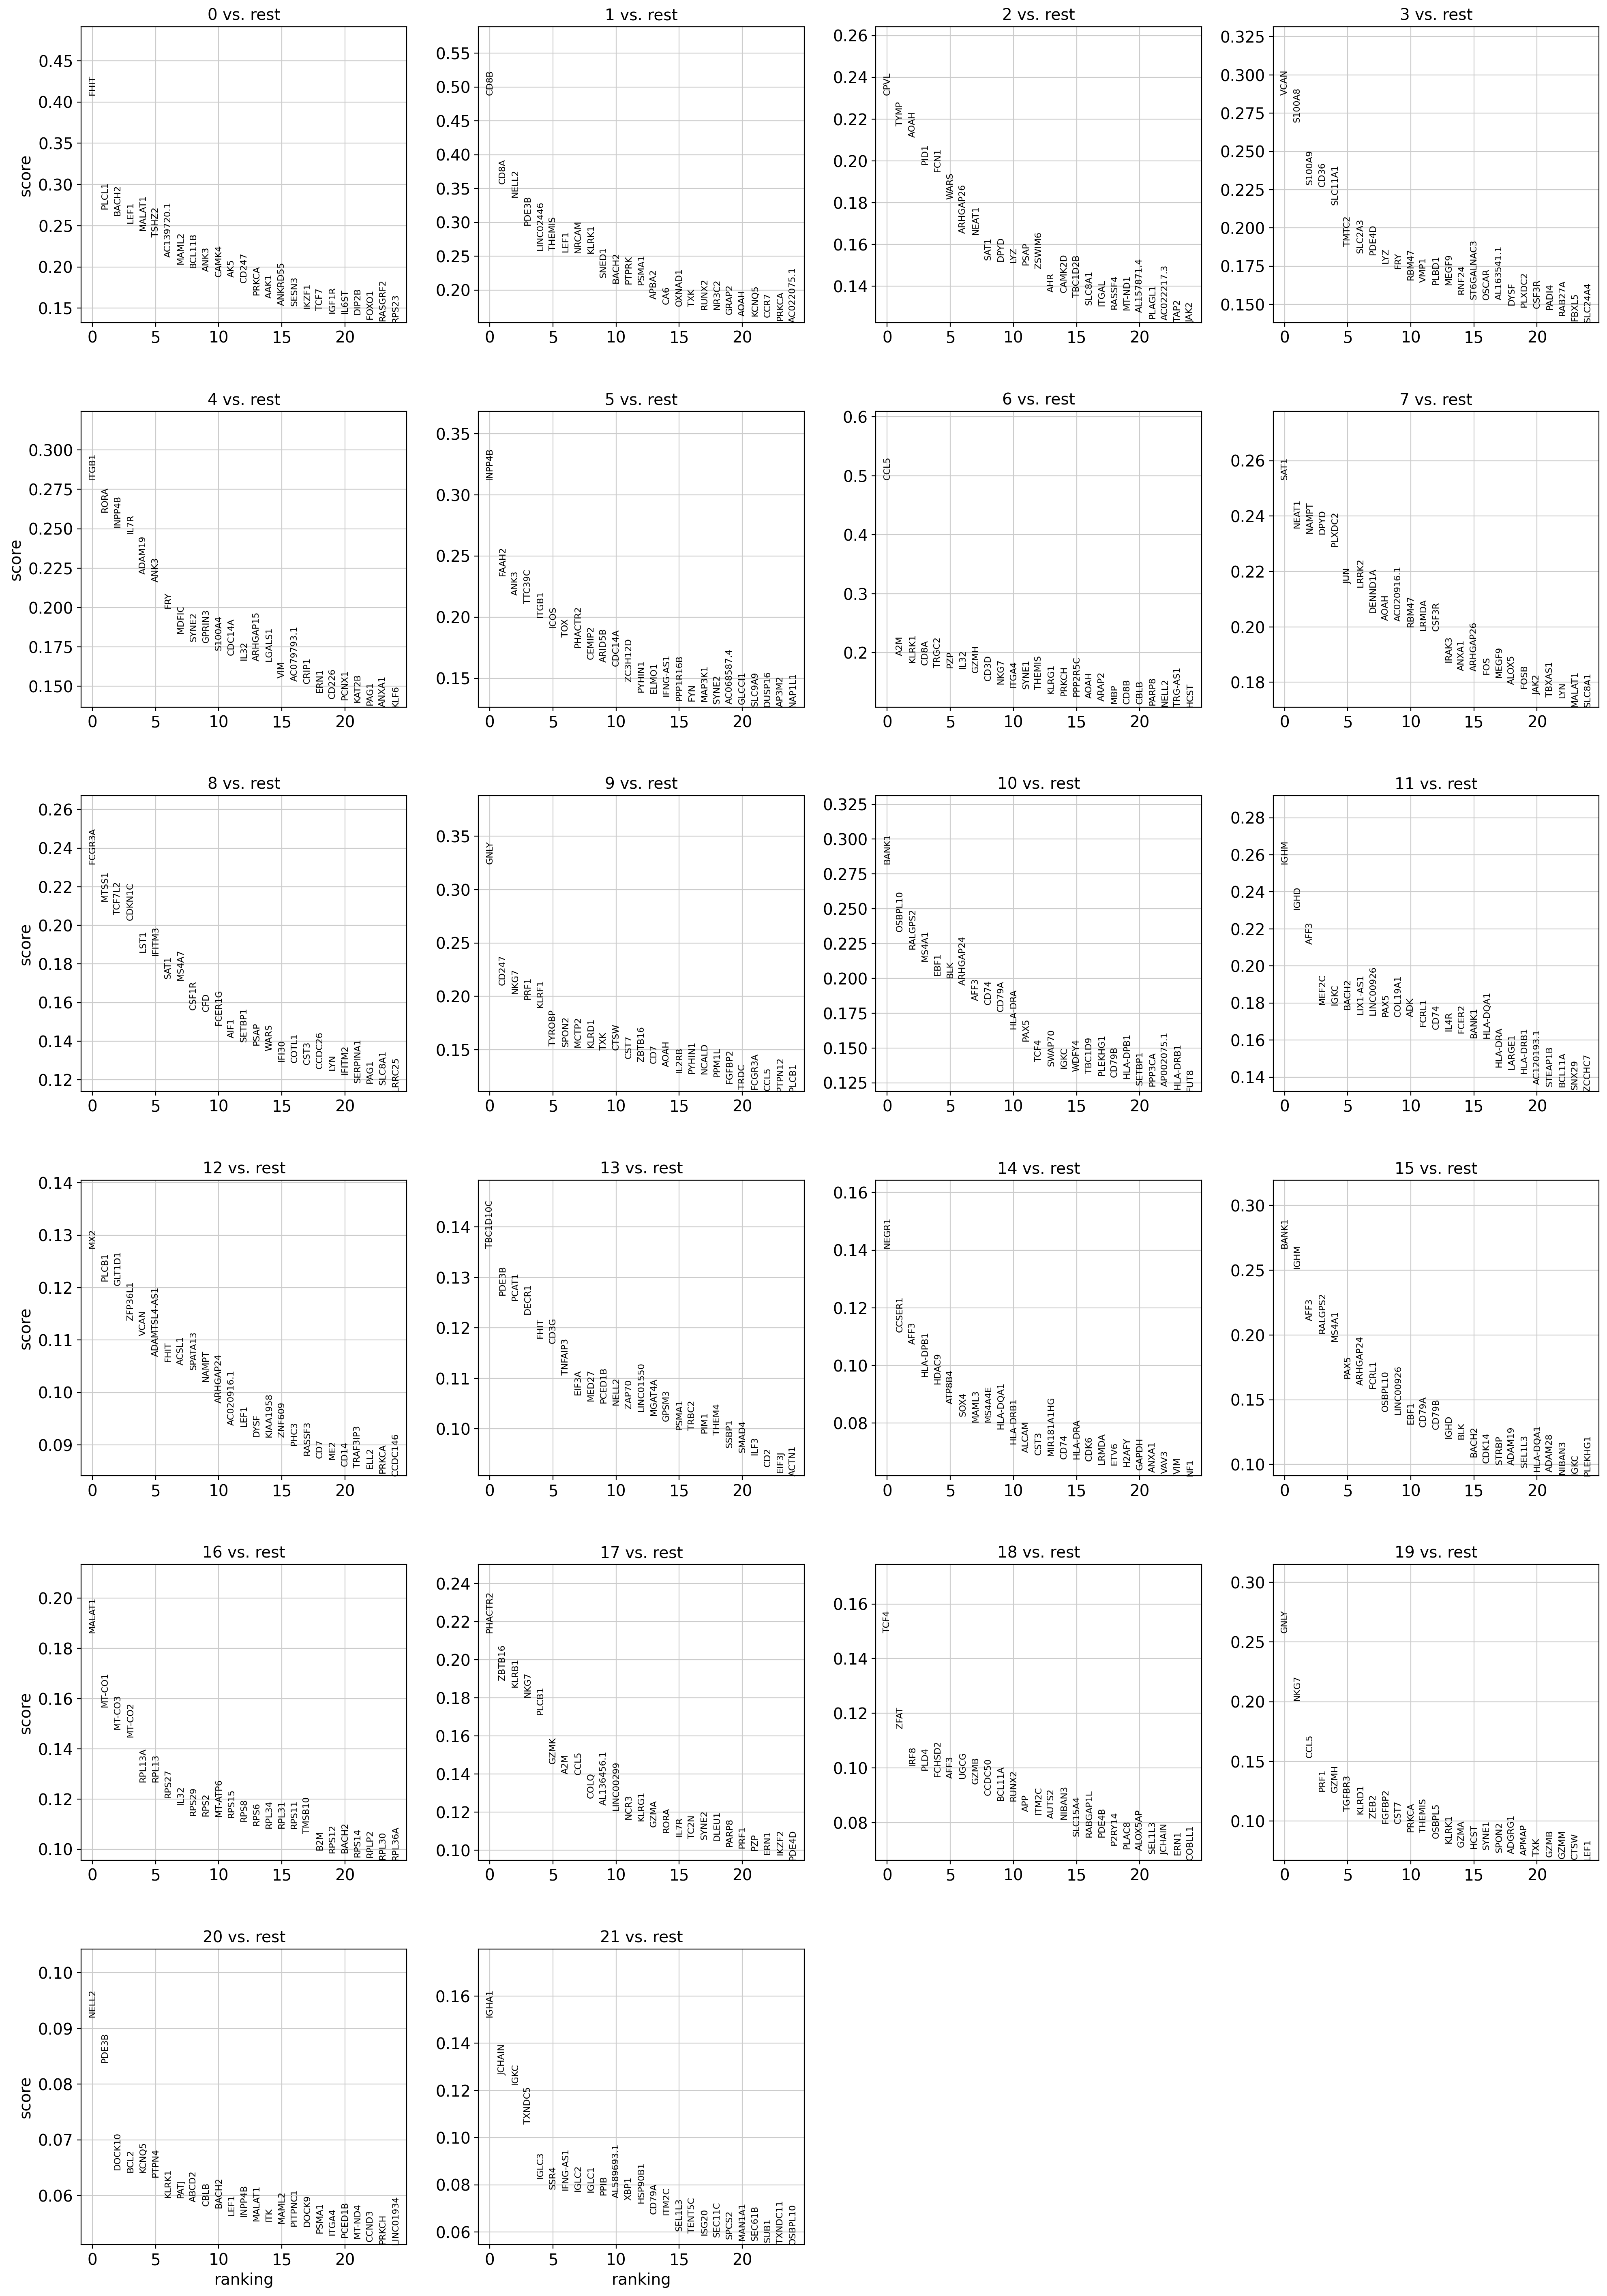

In [ ]:
marker(adata)

In [ ]:
marker_genes = ['LCK','CD3D','KLRD1','SPI1','MS4A1','CD36','IL7R', 'CD79A',
                'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'CST3']
#'FCER1A',"CD3E","CD3G","CD3D","CD2","KLRD1","NCAM1","NKG7","NCR1","FCGR3A","CD3D-","CD3E-","CD8A-",
#"CD4-","LCK-","LYZ","CD14","MAFB","MSR1"]

In [ ]:
adata = sc.read(results_file)
adata.uns['log1p']["base"] = None #add this workaround to solve pbmc10k data issue which cause error
                   #Fix checking of log1p transformation base value when that value is None

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1       2       3       4       5     6         7       8  \
0    LEF1    LEF1    TYMP    VCAN   ITGB1  INPP4B  CCL5      DPYD    PSAP   
1    FHIT   PDE3B  SLC8A1    DPYD     LTB    ANK3  NKG7     NEAT1  TCF7L2   
2  MALAT1   NELL2    AOAH   LRMDA    IL32  CDC14A  IL32    PLXDC2  IFITM3   
3  BCL11B  THEMIS     LYZ  PLXDC2  INPP4B     LTB  GZMA  ARHGAP26    AIF1   
4   CAMK4   BACH2    JAK2  S100A8    IL7R  TTC39C   A2M     NAMPT    LST1   

       9  ...      12      13        14     15     16       17      18     19  \
0   GNLY  ...    VCAN  INPP4B  HLA-DPB1  BANK1  RPS29  PHACTR2    TCF4   GNLY   
1   PRF1  ...   CSF3R    IL7R      CST3  MS4A1  RPS12    KLRB1    ZFAT   NKG7   
2   NKG7  ...  PLXDC2   CAMK4  HLA-DRB1   PAX5  RPL13     NKG7    IRF8   PRF1   
3  CD247  ...    DPYD  BCL11B  HLA-DPA1   AFF3  RPS27   ZBTB16  FCHSD2  KLRD1   
4  KLRD1  ...   LRMDA    LEF1      CD74  FCRL1  RPS14      A2M    UGCG   CCL5   

         20       21  
0    DOCK10     PPIB  
1     NELL2     SSR4  
2  ARHGAP15   TXNDC5  
3     PTPN4   JCHAIN  
4   PITPNC1  HSP90B1  

[5 rows x 22 columns]

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n  1_p     2_n  2_p     3_n  3_p     4_n  \
0    LEF1   0.000000e+00    LEF1  0.0    TYMP  0.0    VCAN  0.0   ITGB1   
1    FHIT   0.000000e+00   PDE3B  0.0  SLC8A1  0.0    DPYD  0.0     LTB   
2  MALAT1   0.000000e+00   NELL2  0.0    AOAH  0.0   LRMDA  0.0    IL32   
3  BCL11B   0.000000e+00  THEMIS  0.0     LYZ  0.0  PLXDC2  0.0  INPP4B   
4   CAMK4  3.834693e-307   BACH2  0.0    JAK2  0.0  S100A8  0.0    IL7R   

             4_p  ...     17_n          17_p    18_n          18_p   19_n  \
0  2.270712e-224  ...  PHACTR2  9.176370e-50    TCF4  2.705025e-74   GNLY   
1  8.242613e-220  ...    KLRB1  4.112695e-46    ZFAT  5.929713e-73   NKG7   
2  1.685700e-212  ...     NKG7  2.677112e-44    IRF8  3.194435e-72   PRF1   
3  2.232772e-208  ...   ZBTB16  1.007537e-39  FCHSD2  1.019688e-71  KLRD1   
4  1.345231e-200  ...      A2M  3.662133e-39    UGCG  1.250858e-71   CCL5   

           19_p      20_n          20_p     21_n          21_p  
0  2.958881e-51    DOCK10  9.746459e-13     PPIB  4.957953e-13  
1  8.377385e-49     NELL2  4.160785e-12     SSR4  6.070100e-13  
2  2.732247e-40  ARHGAP15  3.826062e-11   TXNDC5  1.051320e-12  
3  1.459950e-39     PTPN4  7.102271e-11   JCHAIN  1.405029e-12  
4  3.061196e-34   PITPNC1  7.721829e-11  HSP90B1  1.710155e-12  

[5 rows x 44 columns]

ranking genes
    finished (0:00:03)


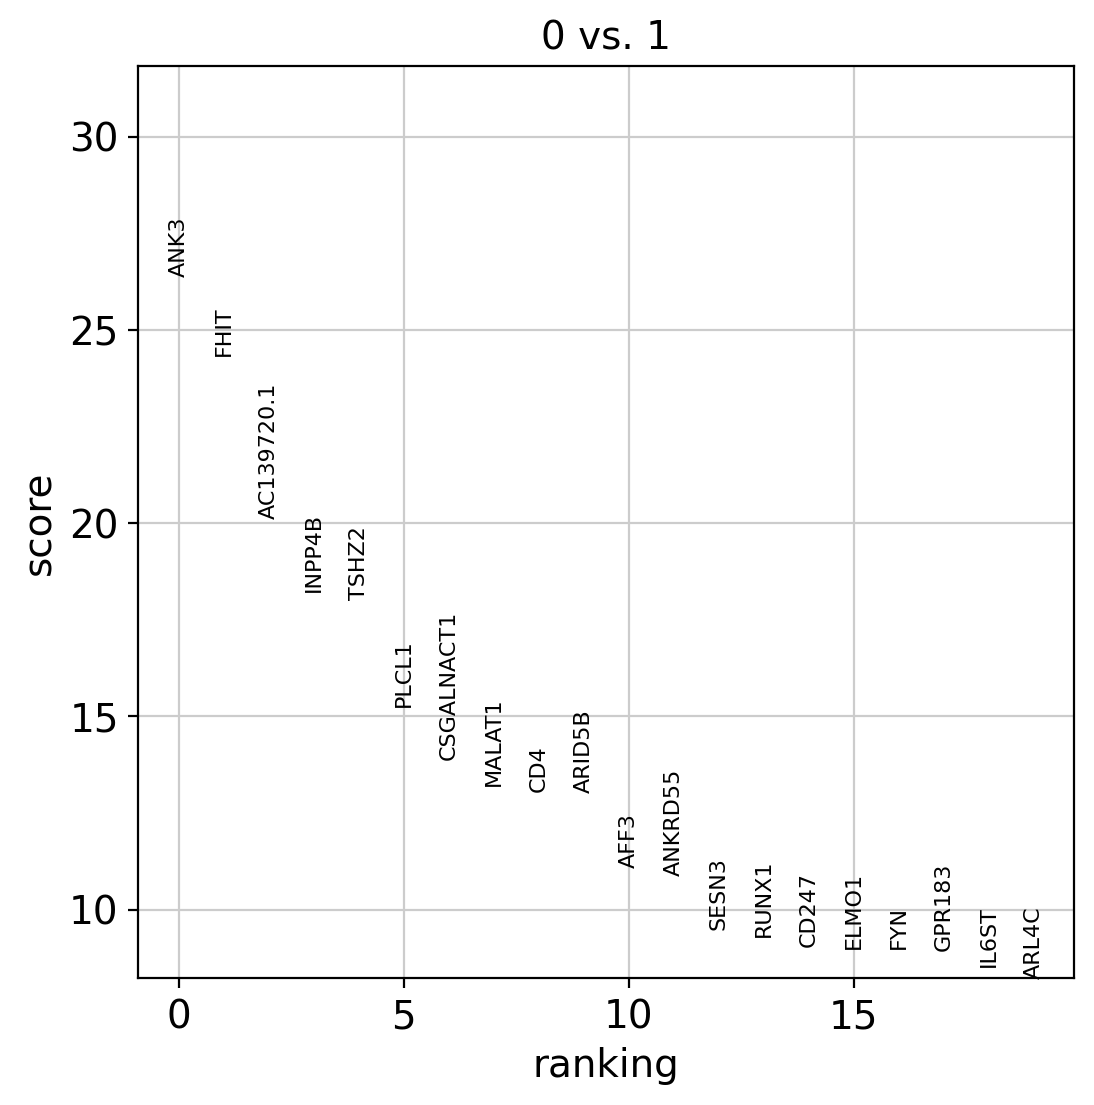

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
#sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:

adata = sc.read(results_file)
#adata.uns['log1p']["base"] = None #add this workaround to solve pbmc10k data issue which cause error
                   #Fix checking of log1p transformation base value when that value is None


'\nadata = sc.read(results_file)\nadata.uns[\'log1p\']["base"] = None #add this workaround to solve pbmc10k data issue which cause error\n                   #Fix checking of log1p transformation base value when that value is None\n'

In [ ]:
#sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
#sc.pl.violin(adata, ['CST3', 'NKG7', 'MS4A1', 'LYZ'], groupby='leiden')

In [ ]:
new_cluster_names = [
"CD4 Naive", "CD4 TCM", "CD4 CTL", "CD4 TEM", "CD4 Proliferating",
"CD8 Naive", "dnT", "CD8 TEM", "CD8 TCM", "CD8 Proliferating",
"MAIT", "NK", "NK_CD56bright", "NK Proliferating", "gdT",
"Treg", "B naive", "B intermediate", "B memory", "Plasmablast"
,"CD14 Mono",'CD16 Mono'                 ]
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontsize=6, legend_fontoutline=1, title='Cell Type', size=20, frameon=False, save='CellType.pdf') # legend_fontsize="xx-small"
sc.pl.umap(adata, color='leiden', title='Cell Type', size=20, frameon=False, save='Cell_Type.pdf')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
#sc.pl.umap(adata, color = ['leiden','top125_eqtl_0'], legend_loc='on data', legend_fontsize=6, legend_fontoutline=1,palette = n_colors_str) #'all762eqtl_0','Peak762_0'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


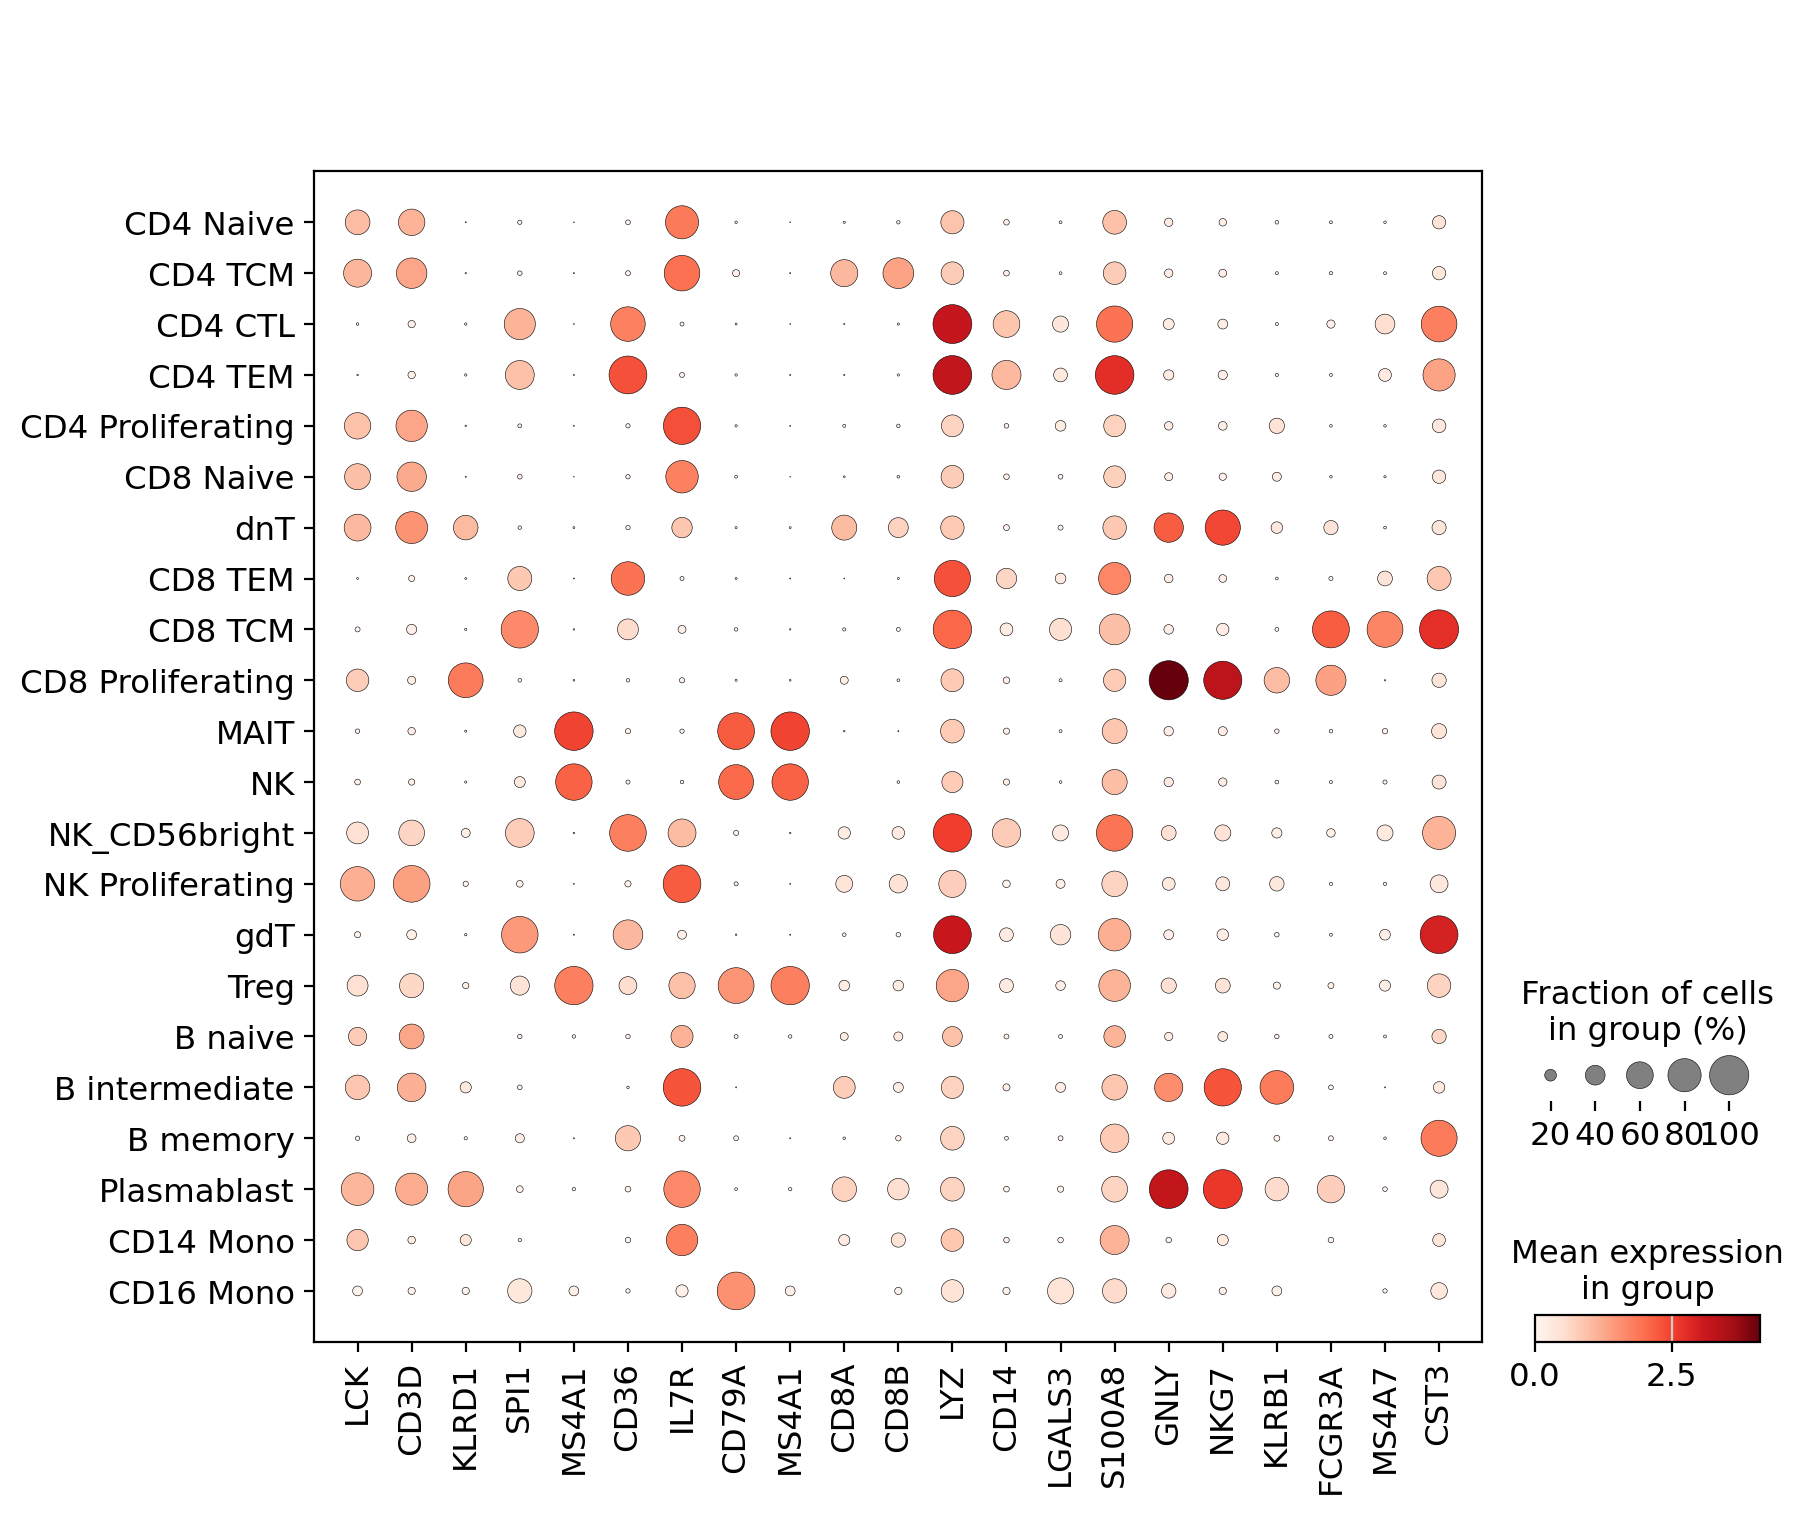

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

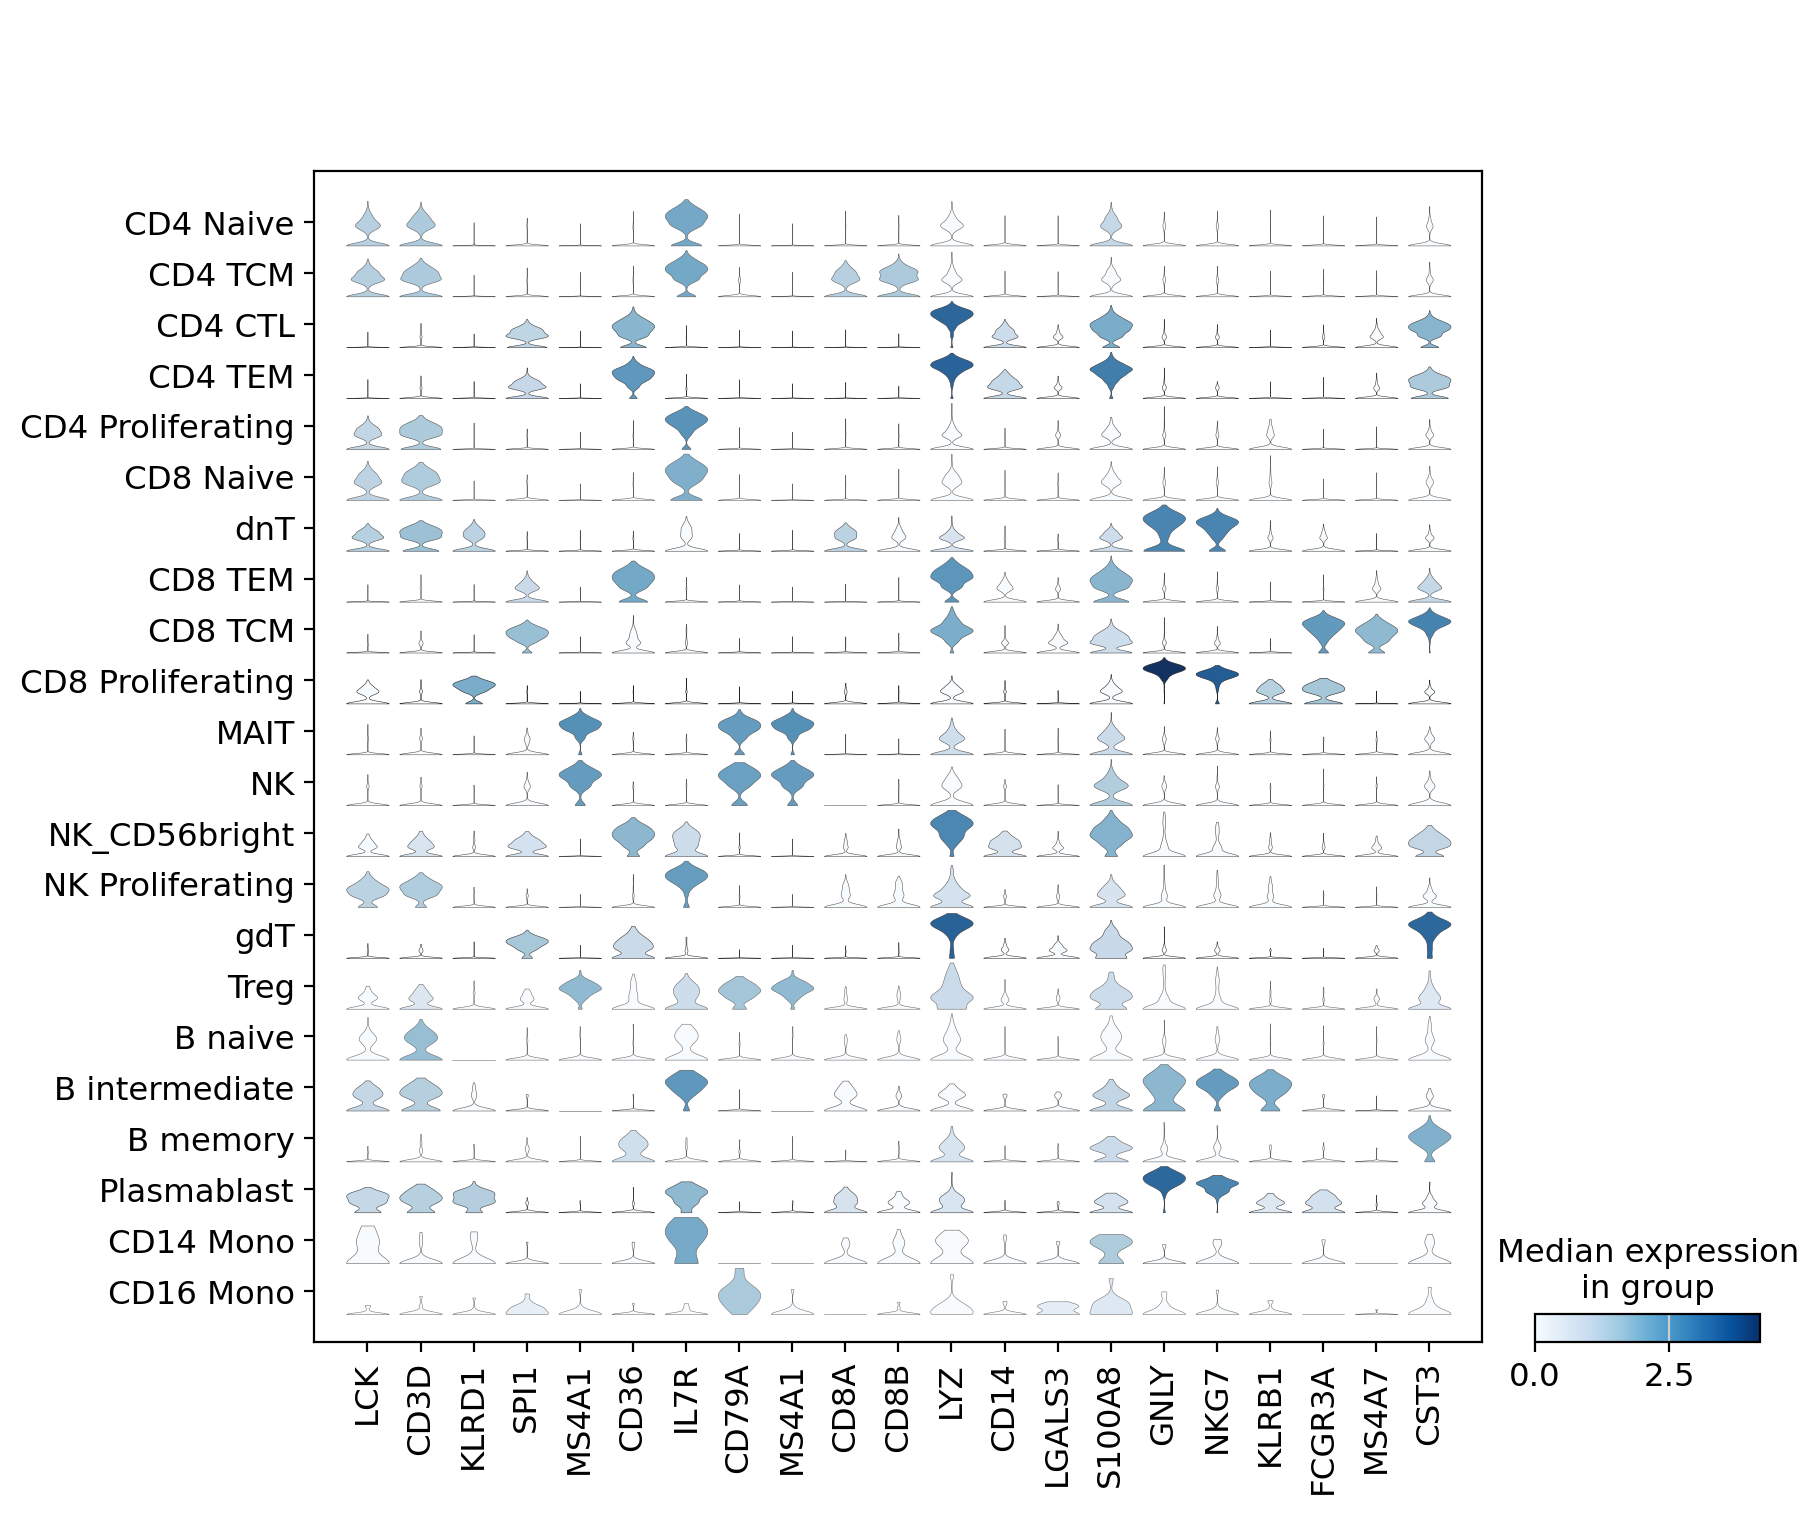

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

In [ ]:
'''adata

SyntaxError: ignored

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [ ]:
adata.raw.to_adata().write('./write/pbmc10k_withoutX.h5ad')

In [ ]:
# Export single fields of the annotation of observations
adata.obs[['n_genes', 'leiden']].to_csv('./write/pbmc10k_corrected_leiden.csv')

# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv('./write/pbmc10k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata.write_csvs(results_file[:-5], )

In [ ]:
#adata.obs.to_csv('./write/pbmc10k_adata_obs.csv')

In [ ]:
#top10 eqtl
#沒有根據原始ATAC檔區分的368個eqtl vs 基因表現差值的all_368eqtl_gexdiff0721.npy
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "Top125_eqtl_0731.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for j in range(125): #
    for i in range(len(all762eqtl_ID)):       #range(len(all_762eqtl_ID))：起始值從0開始，所以會執行0到785(共786次)，但只會找出有在eqtl368_gene中的368個列印出來。
       if all762eqtl_ID[i] == top125_eqtl_ID[j]:
        for k in range(len(eqtl368_geneID0719)):
          if eqtl368_geneID0719[k] == all762eqtl_geneID[i]:
            fig = sc.pl.umap(
                adata,
                color=[f"top125_eqtl_{j:d}",f"all368eqtl_gexdiff0721_{k:d}",'leiden'], #
                title=[all762eqtl_geneID[i],eqtl368_geneID0719[k],'Cell Type'],#'Cell Type"
                frameon=False,
                return_fig=True,
                colorbar_loc = 'right',
                cmap= 'RdBu_r',  #'jet',
                vmin = -3*all368eqtl_gexdiff_std[k],
                vmax = 3*all368eqtl_gexdiff_std[k],
                vcenter = 0,
                #legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
                palette = n_colors_str # 'jet'
            )
            pdf_pages.savefig(fig, bbox_inches="tight")

# 關閉 PDF 物件
pdf_pages.close()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
'''
#沒有根據原始ATAC檔區分的368個eqtl vs 基因表現差值的all_368eqtl_gexdiff0721.npy
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "368eqtl_atac_gexdiff_0723-1.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for j in range(131): #
    for i in range(len(all762eqtl_geneID)):       #range(len(all_762eqtl_ID))：起始值從0開始，所以會執行0到785(共786次)，但只會找出有在eqtl368_gene中的368個列印出來。
       if all762eqtl_geneID[i] == eqtl368_gene0719[j]:
        fig = sc.pl.umap(
            adata,
            color=[f"all_762eqtl_{i:d}",f"all368eqtl_gexdiff0721_{j:d}",'leiden'], #
            title=[all762eqtl_geneID[i],eqtl368_gene0719[j],'Cell Type'],#'Cell Type"
            frameon=False,
            return_fig=True,
            colorbar_loc = 'right', cmap='RdBu',vmin = -0.1,vmax = 0.1, vcenter = 0,
            #legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
        )
        pdf_pages.savefig(fig, bbox_inches="tight")

# 關閉 PDF 物件
pdf_pages.close()


In [ ]:
'''
#沒有根據原始ATAC檔區分的368個eqtl vs 基因表現差值的all_368eqtl_gexdiff0721.npy
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "368eqtl_atac_gexdiff_0723-2.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for j in range(262,368): #len(all368eqtl_gexdiff0721) 0-131-262-368
    for i in range(len(all762eqtl_geneID)):       #range(len(all_762eqtl_ID))：起始值從0開始，所以會執行0到785(共786次)，但只會找出有在eqtl368_gene中的368個列印出來。
       if all762eqtl_geneID[i] == eqtl368_gene0719[j]:
        fig = sc.pl.umap(
            adata,
            color=[f"all_762eqtl_{i:d}",f"all368eqtl_gexdiff0721_{j:d}",'leiden'],
            title=[all762eqtl_geneID[i],eqtl368_gene0719[j],'Cell Type'],#,'Cell Type'
            frameon=False,
            return_fig=True,
            colorbar_loc = 'right', cmap='RdBu',vmin = -0.1,vmax = 0.1, vcenter = 0,
            #legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
        )
        pdf_pages.savefig(fig, bbox_inches="tight")

# 關閉 PDF 物件
pdf_pages.close()

In [ ]:
'''
#沒有根據原始ATAC檔區分的368個eqtl vs 基因表現差值的all_368eqtl_gexdiff0721.npy
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "368eqtl_atac_gexdiff_0721.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for i in range(len(all368eqtl_gexdiff0721)): #range(len(eqtl368_gene))：起始值從0開始，所以會產生0到368的整數序列。

  fig = sc.pl.umap(
    adata,
    color=[f"all368eqtl_gexdiff0721_{i:d}"], #'leiden'
    title=eqtl368_gene0719[i],
    frameon=False,
    return_fig=True,
    colorbar_loc = 'right', cmap='RdBu_r',vmin = -0.1,vmax = 0.1,vcenter = 0,
    #legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()


In [ ]:
'''
#沒有根據原始ATAC檔區分的368個eqtl影響基因位於model include(min cell>500)，基因共355個(備註:使用上方檔案取有出現的，基因名有些需去除addition部分)
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "368eqtl_atac_gene_0721-1.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)
'''
'''
for i in range(len(all762eqtl_ID)): #range(len(all762eqtl_ID))：起始值從0開始，所以會產生0到785的整數序列。

  fig = sc.pl.umap(
    adata,
    color=[f"all_762eqtl_{i:d}"], #,'leiden'
    title=all762eqtl_ID[i],
    frameon=False,
    return_fig=True,
    legend_loc='on data',
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()
'''
'''
for j in range(len(eqtl368_gene0719)): #
    for i in range(len(all762eqtl_geneID)):       #range(len(all_762eqtl_ID))：起始值從0開始，所以會執行0到785(共786次)，但只會找出有在eqtl368_gene中的368個列印出來。
       if all762eqtl_geneID[i] == eqtl368_gene0719[j]:
        fig = sc.pl.umap(
            adata,
            color=[f"all_762eqtl_{i:d}",f"all_368eqtl_{j:d}"], #,'Cell Type'
            title=[all762eqtl_geneID[i],eqtl368_gene0719[j]],
            frameon=False,
            return_fig=True,
            #legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
        )
        pdf_pages.savefig(fig, bbox_inches="tight")

# 關閉 PDF 物件
pdf_pages.close()
'''

'''
for i in range(len(all762eqtl_ID)): #range(len(all_762eqtl_ID))：起始值從0開始，所以會執行0到785(共786次)，但只會找出有在eqtl368_gene中的368個列印出來。
    if all762eqtl_geneID[i] in eqtl368_gene:
        fig = sc.pl.umap(
            adata,
            color=[f"all_762eqtl_{i:d}",'leiden'], #
            title=all762eqtl_geneID[i],
            frameon=False,
            return_fig=True,
            legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
        )
        pdf_pages.savefig(fig, bbox_inches="tight")

# 關閉 PDF 物件
pdf_pages.close()
'''
'''
for i in range(len(eqtl368_gene0719)): #range(len(eqtl368_gene))：起始值從0開始，所以會產生0到368的整數序列。

  fig = sc.pl.umap(
    adata,
    color=[f"all_368eqtl_{i:d}",'leiden'],
    title=eqtl368_gene0719[i],
    frameon=False,
    return_fig=True,
    #legend_loc='on data',legend_fontsize=6, legend_fontoutline=1,
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()
'''

In [ ]:
'''#執行gs來合併或壓縮pdf檔

In [ ]:
!apt-get install ghostscript

In [ ]:
import shutil
gs_path = shutil.which('gs')

In [ ]:
import os
import subprocess

def merge_pdfs(folder_path, output_file):
    pdf_files = [file for file in os.listdir(folder_path) if file.endswith('.pdf')]
    pdf_files.sort()  # 确保文件按名称排序

    # 构建Ghostscript命令
    gs_command = [gs_path, '-dBATCH', '-dNOPAUSE', '-q', '-sDEVICE=pdfwrite', '-sOutputFile=' + output_file]

    # 添加所有PDF文件到命令
    for pdf_file in pdf_files:
        gs_command.append(os.path.join(folder_path, pdf_file))

    # 调用Ghostscript执行PDF合并
    subprocess.run(gs_command)

# 设置文件夹路径和输出文件名
folder_path = '/content'  # 替换为实际的文件夹路径
output_file = '/content/output1.pdf'  # 替换为实际的输出文件路径和名称

# 调用函数进行PDF合并
merge_pdfs(folder_path, output_file)


In [ ]:
'''#有根據原始ATAC檔區分的 0-392
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "all762eqtl_changestate3group0714-1.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for i in range(393): #len(all762eqtl_ID)
  fig = sc.pl.umap(
    adata,
    color=[f"all762eqtl_{i:d}",'leiden'],
    title=all762eqtl_ID[i],
    frameon=False,
    return_fig=True,
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()


In [ ]:
'''#有根據原始ATAC檔區分的 393-786
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "all762eqtl_changestate3group0714-2.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for i in range(393,len(all762eqtl_ID)): #range(393,len(all762eqtl_ID))：起始值從393開始，所以會產生393到786的整數序列。
  fig = sc.pl.umap(
    adata,
    color=[f"all762eqtl_{i:d}",'leiden'],
    title=all762eqtl_ID[i],
    frameon=False,
    return_fig=True,
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()
'''

In [ ]:
'''#沒有根據原始ATAC檔區分的 all786
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "all_762eqtl_changestate3group0715-1.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for i in range(len(all762eqtl_ID)): #range(len(all_762eqtl_ID))：起始值從0開始，所以會產生0到785的整數序列。
  fig = sc.pl.umap(
    adata,
    color=[f"all_762eqtl_{i:d}"], #,'leiden'
    title=all762eqtl_ID[i],
    frameon=False,
    return_fig=True,
    legend_loc='on data',
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()
'''

In [ ]:
'''#沒有根據原始ATAC檔區分的 0-392
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "all_762eqtl_changestate3group0714-1.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for i in range(393): #range(393)：起始值從0開始，所以會產生0到392的整數序列。
  fig = sc.pl.umap(
    adata,
    color=[f"all_762eqtl_{i:d}",'leiden'],
    title=all762eqtl_geneID[i],
    frameon=False,
    return_fig=True,
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()
'''

In [ ]:
'''#沒有根據原始ATAC檔區分的 393-786
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt # matplotlib.use('agg')必须在本句执行前运行
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = "all_762eqtl_changestate3group0714-2.pdf"  # PDF 檔案名稱

# 建立一個 PDF 物件
pdf_pages = PdfPages(pdf_file)

for i in range(393,len(all762eqtl_geneID)): #range(393,len(all_762eqtl_ID))：起始值從393開始，所以會產生393到786的整數序列。
  fig = sc.pl.umap(
    adata,
    color=[f"all_762eqtl_{i:d}",'leiden'],
    title=all762eqtl_geneID[i],
    frameon=False,
    return_fig=True,
    )
  pdf_pages.savefig(fig, bbox_inches="tight")
# 關閉 PDF 物件
pdf_pages.close()
'''

In [ ]:
#!pip install --upgrade PyPDF4

In [ ]:
'''import os
from PyPDF4 import PdfMerger

def merge_pdfs(folder_path, output_file):
    merger = PdfMerger()

    # 遍历文件夹中的所有PDF文件
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)

            # 将PDF文件添加到合并器中
            with open(file_path, 'rb') as file:
                merger.append(file)

    # 合并PDF文件
    with open(output_file, 'wb') as output:
        merger.write(output)

# 设置文件夹路径和输出文件名
folder_path = '/content/'  # 替换为实际的文件夹路径
output_file = '/content/output.pdf'  # 替换为实际的输出文件路径和名称

# 调用函数进行PDF合并
merge_pdfs(folder_path, output_file)


In [ ]:
#!pip install --upgrade PyPDF2

In [ ]:
'''import os
from PyPDF2 import PdfMerger

def merge_pdfs(folder_path, output_file):
    merger = PdfMerger()

    # 遍历文件夹中的所有文件
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)

            # 将PDF文件添加到合并器中
            merger.append(file_path)

    # 合并PDF文件
    merger.write(output_file)
    merger.close()

# 设置文件夹路径和输出文件名
folder_path = '/content'  # 替换为实际的文件夹路径
output_file = '/content/output.pdf'  # 替换为实际的输出文件路径和名称

# 调用函数进行PDF合并
merge_pdfs(folder_path, output_file)


In [ ]:
'''for i in range(0,786): #沒有根據原始ATAC檔區分的 all_762eqtl_threelabelby3group0711
  #sc.pl.umap(adata, color=f"all_762eqtl_{i:d}",title=f"all_762eqtl_changestate3group0711_{i:d}",legend_loc='on data',save=f"all_762eqtl_changestate3group0711_{i:d}.pdf") #用自己檔名當title
  #sc.pl.umap(adata, color=f"all_762eqtl_{i:d}",title=all_762eqtl_ID[i],legend_loc='on data',save=f"all_762eqtl_changestate3group0711_{i:d}.png") #用eQTL ID當title
  sc.pl.umap(adata, color=f"all_762eqtl_{i:d}",title=all762eqtl_ID[i],save=f"all_762eqtl_changestate3group0715_{i:d}.pdf") #用eQTL ID當title

In [ ]:
'''for i in range(0,786): #有根據原始ATAC檔區分的 all762eqtl_changestate3group0711
  #sc.pl.umap(adata, color=f"all762eqtl_{i:d}",title=f"all762eqtl_changestate3group0711_{i:d}",legend_loc='on data',save=f"all762eqtl_changestate3group0711_{i:d}.pdf")
  #sc.pl.umap(adata, color=f"all762eqtl_{i:d}",title=f"all762eqtl_changestate3group0711_{i:d}",legend_loc='on data',save=f"all762eqtl_changestate3group0711_{i:d}.png")
  sc.pl.umap(adata, color=f"all762eqtl_{i:d}",title=all762eqtl_ID[i],save=f"all762eqtl_changestate3group0715_{i:d}.pdf") #用eQTL ID當title

In [ ]:
'''for i in range(0,786): #title改成eQTL ID
  #sc.pl.umap(adata, color=f"all762eqtl_{i:d}",title=f"all762eqtl_changestate3group0703_{i:d}",legend_loc='on data',save=f"all762eqtl_changestate3group0703_{i:d}.pdf")
  sc.pl.umap(adata, color=f"all762eqtl_{i:d}",title=all762eqtl_ID[i],legend_loc='on data',save=f"all762eqtl_changestate3group0703_{i:d}.png")

In [ ]:
'''
for i in range(0,1572):
  sc.pl.umap(adata, color=f"Peak762_{i:d}",title=sb786_index[i],legend_loc='on data',save=f"Peak762_{i:d}.png")
  #sc.pl.umap(adata, color=f"Peak762_{i:d}",title=f"Peak762_{i:d}",save=f"Peak762_{i:d}.pdf")

In [ ]:
#sc.pl.umap(adata, color = ['leiden','Peak762_0','Peak762_1','Peak762_2','Peak762_3','Peak762_4','Peak762_5','Peak762_6',
#                           'Peak762_7','Peak762_8','Peak762_9','Peak762_10','Peak762_11','Peak762_12','Peak762_13',
#                           'Peak762_14','Peak762_15','Peak762_16','Peak762_17',],legend_loc='on data')